# Step 1: Data Preparation and Annotation (Tumor + Normal)

In [3]:
import pandas as pd
import numpy as np

annotation_path = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/rel_ENS_SYM_gencode.v31.primary.csv"
gtex_path       = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/TOIL_GTEX_RSEM_TPM_5_CANCERS.csv"
phenotype_path  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/TOIL_GTEX_PHENOTYPE_5_CANCERS.csv"
skcm_path       = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/TOIL_RSEM_TPM_SKCM.csv"
gtex_skin_out = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin.csv"
skcm_out      = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/TOIL_SKCM_annotated.csv"

annotation = pd.read_csv(annotation_path, sep="\t", header=None, names=["ENSG_ID","type","HGNC_symbol"])
annotation["ENSG_ID"] = annotation["ENSG_ID"].astype(str).str.replace(r"\.\d+$", "", regex=True)
annotation = annotation.drop_duplicates(subset=["ENSG_ID"])

id_cols = ["gene_ID", "HGNC_symbol"]
OFFSET = 1e-3
LOG_FLOOR = float(np.log2(OFFSET))

def load_and_clean_expr(path, cohort_name):
    df = pd.read_csv(path)

    if "Unnamed: 0" in df.columns and "gene_ID" not in df.columns:
        df = df.rename(columns={"Unnamed: 0":"gene_ID"})
    if "gene_ID" not in df.columns:
        first_col = df.columns[0]
        df = df.rename(columns={first_col: "gene_ID"})

    df["gene_ID"] = df["gene_ID"].astype(str).str.replace(r"\.\d+$", "", regex=True)

    if "HGNC_symbol" not in df.columns:
        df = df.merge(annotation[["ENSG_ID","HGNC_symbol"]],
                      left_on="gene_ID", right_on="ENSG_ID", how="left").drop(columns=["ENSG_ID"])
        
    expr_cols = [c for c in df.columns if c not in id_cols]
    df = df[id_cols + expr_cols]

    vals = df[expr_cols].to_numpy().ravel()
    approx_floor = np.nanmin(vals)
    if abs(approx_floor - LOG_FLOOR) > 1e-3:
        raise ValueError(f"{cohort_name}: unexpected scale (min {approx_floor:.4f}, expected ~{LOG_FLOOR:.4f})")

    return df

def collapse_symbols_by_highest_mean(gtex_df, tumor_df):
    def _mean(df):
        cols = [c for c in df.columns if c not in id_cols]
        return df[cols].mean(axis=1)

    tmp_g = gtex_df[id_cols].copy()
    tmp_g["mean_log2TPM"] = _mean(gtex_df)

    tmp_t = tumor_df[id_cols].copy()
    tmp_t["mean_log2TPM"] = _mean(tumor_df)

    both = pd.concat([tmp_g, tmp_t], ignore_index=True)

    keep_map = (both.dropna(subset=["HGNC_symbol"])
                     .sort_values(["HGNC_symbol","mean_log2TPM"], ascending=[True, False])
                     .drop_duplicates(subset=["HGNC_symbol"]))

    canonical_ids = set(keep_map["gene_ID"]) | set(both[both["HGNC_symbol"].isna()]["gene_ID"])

    return (gtex_df[gtex_df["gene_ID"].isin(canonical_ids)].copy(),
            tumor_df[tumor_df["gene_ID"].isin(canonical_ids)].copy())

def filter_low_expr(df, min_detect_prop=0.2):
    expr = df.drop(columns=id_cols, errors="ignore")
    detected = (expr > (LOG_FLOOR + 1e-6))
    keep = detected.mean(axis=1) >= min_detect_prop
    return df.loc[keep].copy()

gtex = load_and_clean_expr(gtex_path, "GTEx")
skcm = load_and_clean_expr(skcm_path, "SKCM")

phenotype = pd.read_csv(phenotype_path)
skin_mask = phenotype["Primary_site"].astype(str).str.contains("Skin", case=False, na=False)
skin_samples = phenotype.loc[skin_mask, "Sample"].astype(str).tolist()

gtex_available = [c for c in gtex.columns if c in skin_samples]
missing = sorted(set(skin_samples) - set(gtex.columns))
print(f"[GTEx] Skin samples found: {len(gtex_available)} ")

gtex_skin = gtex[id_cols + gtex_available].copy()

DO_SYMBOL_COLLAPSE = True
if DO_SYMBOL_COLLAPSE:
    gtex_skin, skcm = collapse_symbols_by_highest_mean(gtex_skin, skcm)

APPLY_LOW_EXPR_FILTER = False
if APPLY_LOW_EXPR_FILTER:
    gtex_skin = filter_low_expr(gtex_skin, min_detect_prop=0.2)
    skcm      = filter_low_expr(skcm,      min_detect_prop=0.2)

gtex_skin.to_csv(gtex_skin_out, index=False)
skcm.to_csv(skcm_out, index=False)

print("GTEx skin shape:", gtex_skin.shape, " (#genes x #columns)")
print("SKCM tumor shape:", skcm.shape,     " (#genes x #columns)")

print("Number of skin (normal) samples:", len([c for c in gtex_skin.columns if c not in id_cols]))
print("Number of tumor samples        :", len([c for c in skcm.columns if c not in id_cols]))
print("Number of genes (GTEx)         :", gtex_skin['gene_ID'].nunique())
print("Number of genes (SKCM)         :", skcm['gene_ID'].nunique())

[GTEx] Skin samples found: 812 
GTEx skin shape: (56389, 814)  (#genes x #columns)
SKCM tumor shape: (56389, 104)  (#genes x #columns)
Number of skin (normal) samples: 812
Number of tumor samples        : 102
Number of genes (GTEx)         : 56389
Number of genes (SKCM)         : 56389


In [5]:
len(missing), missing[:5]
float(gtex_skin.drop(columns=["gene_ID","HGNC_symbol"]).min().min()),
float(skcm.drop(columns=["gene_ID","HGNC_symbol"]).min().min())

def dup_symbols(df):
    x = df[df["HGNC_symbol"].notna()]
    return x.duplicated(subset="HGNC_symbol").sum()
dup_symbols(gtex_skin), dup_symbols(skcm)


(np.int64(0), np.int64(0))

/var/folders/cs/p5f4qmkd3698y4hpfkyvf1gc0000gn/T/ipykernel_1934/1042880065.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Group", y="log2TPM", data=combined, palette=pal, width=0.6)


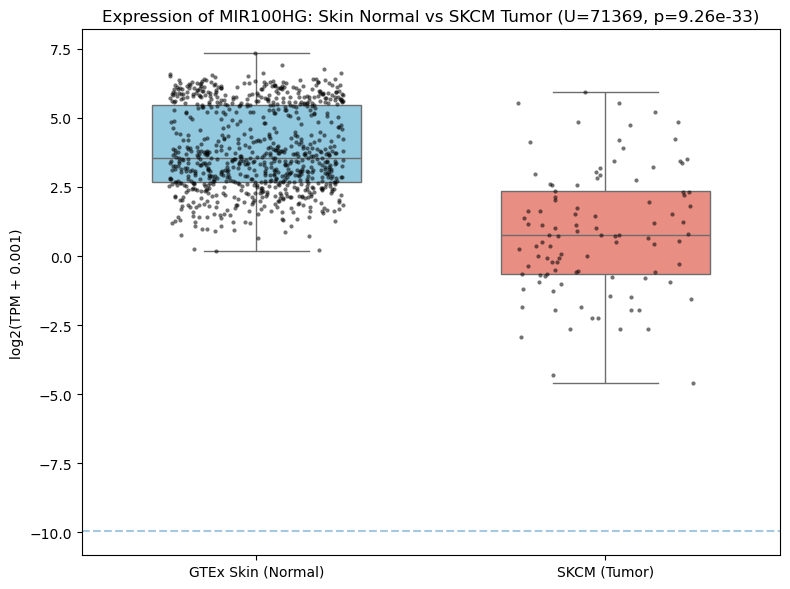

Mann–Whitney U=71369, p-value=9.259e-33


In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

gene_of_interest = "MIR100HG"

gtex_gene = gtex_skin[gtex_skin["HGNC_symbol"] == gene_of_interest]
skcm_gene = skcm[skcm["HGNC_symbol"] == gene_of_interest]

if gtex_gene.empty or skcm_gene.empty:
    raise ValueError(f"{gene_of_interest} not found in one of the matrices. "
                     f"GTEx found={not gtex_gene.empty}, SKCM found={not skcm_gene.empty}")

gtex_melted = gtex_gene.drop(columns=id_cols, errors="ignore").melt(var_name="Sample", value_name="log2TPM")
gtex_melted["Group"] = "GTEx Skin (Normal)"

skcm_melted = skcm_gene.drop(columns=id_cols, errors="ignore").melt(var_name="Sample", value_name="log2TPM")
skcm_melted["Group"] = "SKCM (Tumor)"

combined = pd.concat([gtex_melted, skcm_melted], ignore_index=True)

U, p = mannwhitneyu(gtex_melted["log2TPM"], skcm_melted["log2TPM"], alternative="two-sided")

pal = {"GTEx Skin (Normal)": "skyblue", "SKCM (Tumor)": "salmon"}
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="Group", y="log2TPM", data=combined, palette=pal, width=0.6)
sns.stripplot(x="Group", y="log2TPM", data=combined, color="black", alpha=0.55, jitter=0.25, size=3)
plt.axhline(LOG_FLOOR, ls="--", alpha=0.4)
plt.title(f"Expression of {gene_of_interest}: Skin Normal vs SKCM Tumor (U={U:.0f}, p={p:.2e})")
plt.ylabel("log2(TPM + 0.001)")
plt.xlabel("")
plt.tight_layout()
plt.show()

print(f"Mann–Whitney U={U:.0f}, p-value={p:.3e}")


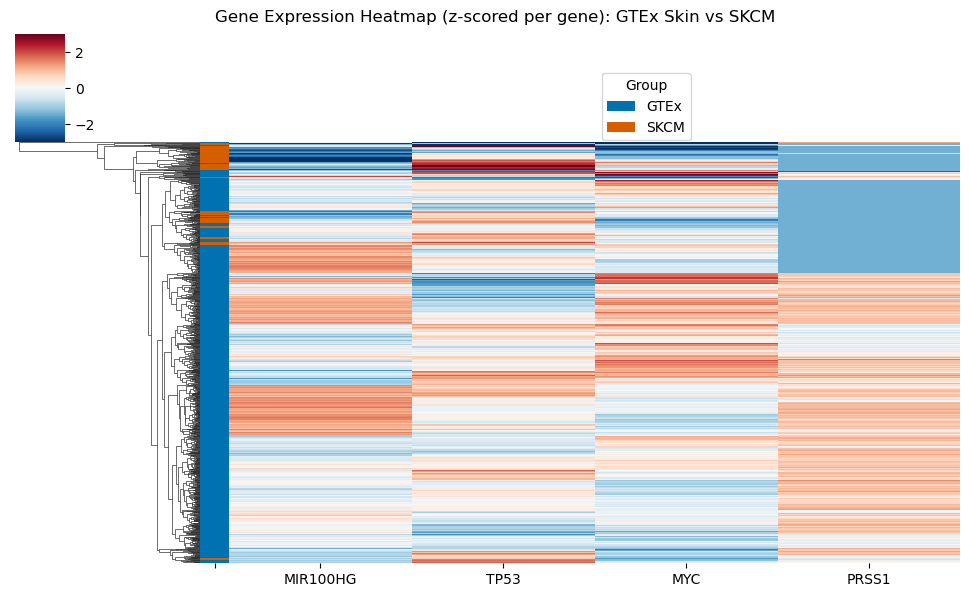

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

genes_of_interest = ["MIR100HG", "TP53", "MYC", "PRSS1"]

gtex_filtered = gtex_skin[gtex_skin["HGNC_symbol"].isin(genes_of_interest)].copy()
skcm_filtered = skcm[skcm["HGNC_symbol"].isin(genes_of_interest)].copy()

present = set(gtex_filtered["HGNC_symbol"]) | set(skcm_filtered["HGNC_symbol"])
missing = [g for g in genes_of_interest if g not in present]
if missing:
    print("Missing genes (in one or both cohorts):", missing)

gtex_filtered["Group"] = "GTEx"
skcm_filtered["Group"] = "SKCM"
combined = pd.concat([gtex_filtered, skcm_filtered], ignore_index=True)

id_cols = ["gene_ID", "HGNC_symbol"]  
expression_cols = [c for c in combined.columns if c not in id_cols + ["Group"]]
melted = combined.melt(id_vars=["HGNC_symbol","Group"], value_vars=expression_cols,
                       var_name="Sample", value_name="log2TPM")
heatmap_data = melted.pivot_table(index="Sample", columns="HGNC_symbol", values="log2TPM")

z = (heatmap_data - heatmap_data.mean(axis=0)) / heatmap_data.std(axis=0, ddof=0)
z = z.fillna(0.0)
z = z[[g for g in genes_of_interest if g in z.columns]]

gtex_samples = gtex_filtered.columns.difference(id_cols + ["Group"]).tolist()
skcm_samples = skcm_filtered.columns.difference(id_cols + ["Group"]).tolist()
sample_to_group = pd.Series({s: "GTEx" for s in gtex_samples} | {s: "SKCM" for s in skcm_samples})

group_colors = {"GTEx": "#0072B2", "SKCM": "#D55E00"}  
row_colors = sample_to_group.reindex(z.index).map(group_colors)

order = z.index.to_series().map(sample_to_group).sort_values(kind="stable").index
z2 = z.loc[order]
row_colors = row_colors.loc[order]

from matplotlib.patches import Patch
legend_elems = [Patch(facecolor=group_colors["GTEx"], label="GTEx"),
                Patch(facecolor=group_colors["SKCM"],  label="SKCM")]

g = sns.clustermap(
    z2,
    cmap="RdBu_r", center=0, vmin=-3, vmax=3,
    row_colors=row_colors,
    col_cluster=False,
    yticklabels=False, xticklabels=True,
    figsize=(10, 6)
)

g.ax_heatmap.set_xlabel("")
g.ax_heatmap.set_ylabel("")
z2.index.name = None
z2.columns.name = None

g.ax_heatmap.legend(handles=legend_elems, title="Group",
                    loc="upper left", bbox_to_anchor=(0.5, 1.18))
plt.suptitle("Gene Expression Heatmap (z-scored per gene): GTEx Skin vs SKCM", y=1.02)
plt.show()


# Step 2: MIR100HG Stratification (Tumor Only + Normal)

In [21]:
try:
    import mygene
    mg = mygene.MyGeneInfo()
    mir100hg_info = mg.query("MIR100HG", scopes="symbol", fields="ensembl.gene", species="human")
    for hit in mir100hg_info.get('hits', []):
        ens_field = hit.get('ensembl')
        if isinstance(ens_field, list):
            genes = {e.get('gene') for e in ens_field if isinstance(e, dict)}
        elif isinstance(ens_field, dict):
            genes = {ens_field.get('gene')}
        else:
            genes = set()
        print(hit.get('symbol'), ":", ", ".join(sorted(g for g in genes if g)))
except Exception as e:
    print("mygene lookup skipped:", e)

Input sequence provided is already in string format. No operation performed


None : ENSG00000255248


N SKCM tumor samples used for MIR100HG: 102

Group sizes:
 ENSG00000255248
Low_MIR100HG     26
High_MIR100HG    26
Name: count, dtype: int64
Saved: /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/MIR100HG_top25_bottom25_stratification_SKCM.csv


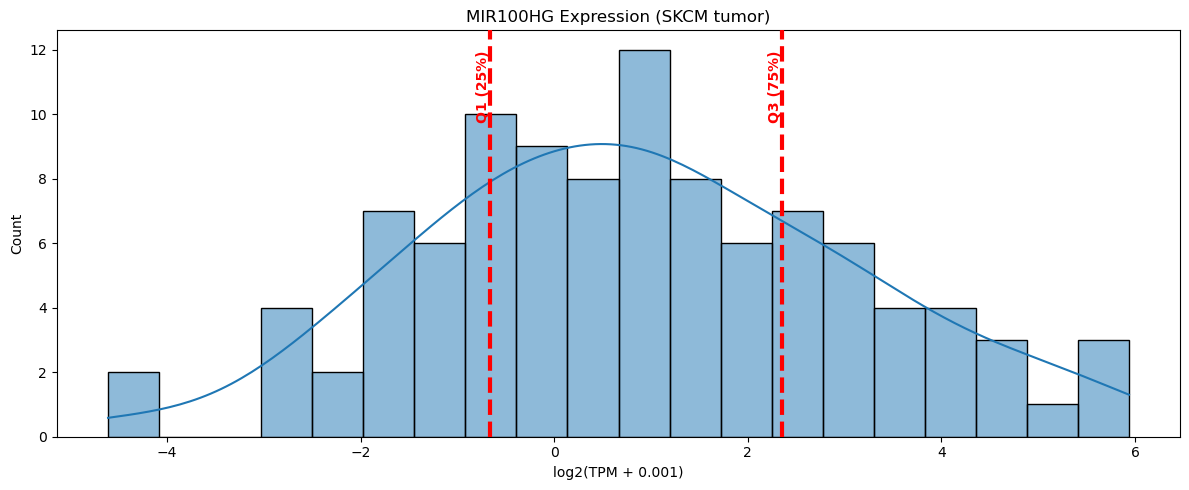

In [11]:
skcm_file = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/TOIL_SKCM_annotated.csv"
df = pd.read_csv(skcm_file, index_col=0)  

mir_id = "ENSG00000255248"  
id_cols = ["HGNC_symbol"]  

if mir_id not in df.index:
    raise ValueError(f"{mir_id} not found in index.")

expr_cols = [c for c in df.columns if c not in id_cols]
mir_expr_numeric = pd.to_numeric(df.loc[mir_id, expr_cols], errors='coerce')

print("N SKCM tumor samples used for MIR100HG:", mir_expr_numeric.notna().sum())

q_labels = pd.qcut(mir_expr_numeric, q=4, labels=["Q1","Q2","Q3","Q4"], duplicates="drop")
group_map = {"Q1":"Low_MIR100HG", "Q4":"High_MIR100HG"}
strat_series = q_labels.map(group_map)
strat_filtered = strat_series.dropna()  

print("\nGroup sizes:\n", strat_filtered.value_counts())

strat_filtered_df = pd.DataFrame({
    "Sample_ID": strat_filtered.index,
    "MIR100HG_Group": strat_filtered.values,
    "MIR100HG_log2TPM": mir_expr_numeric.loc[strat_filtered.index].values
})

out_strat = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/MIR100HG_top25_bottom25_stratification_SKCM.csv"
strat_filtered_df.to_csv(out_strat, index=False)
print("Saved:", out_strat)

plt.figure(figsize=(12, 5))
ax = sns.histplot(mir_expr_numeric, kde=True, bins=20)
ax.set_title("MIR100HG Expression (SKCM tumor)")
ax.set_xlabel("log2(TPM + 0.001)")
ax.set_ylabel("Count")

q_edges = np.quantile(mir_expr_numeric.dropna(), [0.25, 0.75])
for qv, lab in zip(q_edges, ["Q1 (25%)", "Q3 (75%)"]):
    ax.axvline(qv, linestyle="--", color="red", linewidth=3, alpha=1, zorder=5)
    ax.text(qv, ax.get_ylim()[1]*0.95, lab, rotation=90,
            va="top", ha="right", color="red", fontweight="bold")

plt.tight_layout()
plt.show()

In [13]:
high_ids = strat_filtered_df.loc[strat_filtered_df["MIR100HG_Group"]=="High_MIR100HG","Sample_ID"].tolist()
low_ids  = strat_filtered_df.loc[strat_filtered_df["MIR100HG_Group"]=="Low_MIR100HG","Sample_ID"].tolist()

missing_high = [s for s in high_ids if s not in expr_cols]
missing_low  = [s for s in low_ids  if s not in expr_cols]
assert not missing_high and not missing_low, "Some stratified samples not found in SKCM matrix."

print(f"High group n={len(high_ids)}, Low group n={len(low_ids)}")

df_high = df.loc[:, ["HGNC_symbol"] + high_ids]
df_low  = df.loc[:, ["HGNC_symbol"] + low_ids]
df_high.to_csv("/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/SKCM_high_MIR100HG.csv", index=True)
df_low.to_csv ("/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/SKCM_low_MIR100HG.csv",  index=True)


High group n=26, Low group n=26


In [27]:
high_path = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/SKCM_high_MIR100HG.csv"
low_path  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/SKCM_low_MIR100HG.csv"

for name, path in [("HIGH", high_path), ("LOW", low_path)]:
    tmp = pd.read_csv(path)
    id_cols2 = ["gene_ID","HGNC_symbol"]
    sample_cols = [c for c in tmp.columns if c not in id_cols2]
    print(f"{name}: shape={tmp.shape}  -> genes={tmp.shape[0]}, samples={len(sample_cols)}")
    vmin = tmp[sample_cols].min().min()
    print(f"{name}: min value ~ {vmin:.4f} (should be ~ -9.966)\n")

HIGH: shape=(56389, 28)  -> genes=56389, samples=26
HIGH: min value ~ -9.9658 (should be ~ -9.966)

LOW: shape=(56389, 28)  -> genes=56389, samples=26
LOW: min value ~ -9.9658 (should be ~ -9.966)



# Stratification for normal data

N normal (skin) samples used for MIR100HG: 812

Normal group sizes:
 ENSG00000255248
Low_MIR100HG     203
High_MIR100HG    203
Name: count, dtype: int64
Saved: /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin_MIR100HG_top25_bottom25_stratification.csv


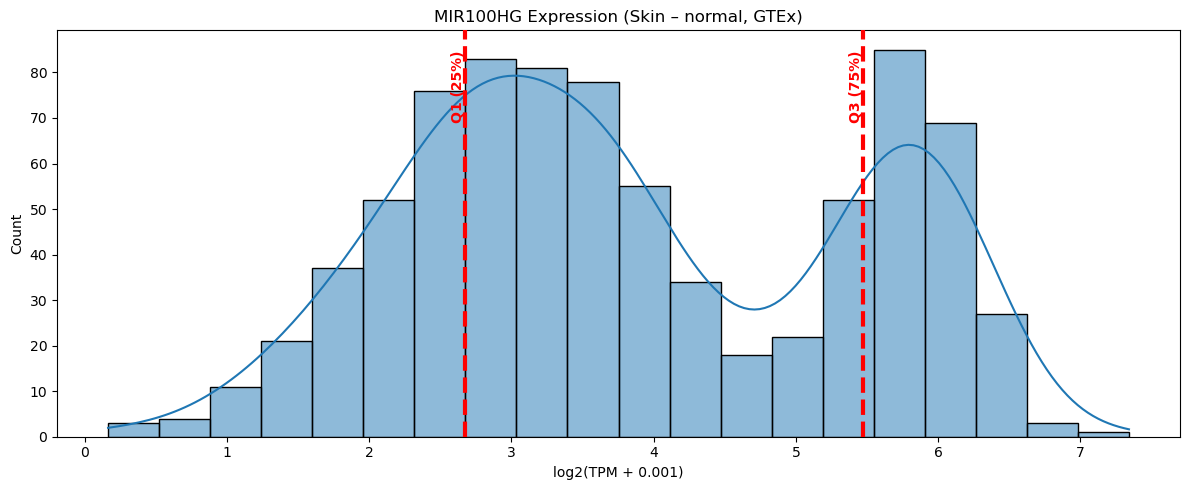

Normal High group n=203, Low group n=203
Saved: /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin_high_MIR100HG.csv
Saved: /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin_low_MIR100HG.csv


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

normal_path = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin.csv"
outdir      = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output"

df_n = pd.read_csv(normal_path, index_col=0)  
mir_id = "ENSG00000255248"                    
id_cols = ["HGNC_symbol"]                     

if mir_id not in df_n.index:
    raise ValueError(f"{mir_id} not found in index of {normal_path}")

expr_cols_n = [c for c in df_n.columns if c not in id_cols]
mir_expr_n = pd.to_numeric(df_n.loc[mir_id, expr_cols_n], errors='coerce')

print("N normal (skin) samples used for MIR100HG:", mir_expr_n.notna().sum())

q_labels_n = pd.qcut(mir_expr_n, q=4, labels=["Q1","Q2","Q3","Q4"], duplicates="drop")
group_map = {"Q1":"Low_MIR100HG", "Q4":"High_MIR100HG"}
strat_n = q_labels_n.map(group_map).dropna()

print("\nNormal group sizes:\n", strat_n.value_counts())

strat_n_df = pd.DataFrame({
    "Sample_ID": strat_n.index,
    "MIR100HG_Group": strat_n.values,
    "MIR100HG_log2TPM": mir_expr_n.loc[strat_n.index].values
})

out_strat_n = f"{outdir}/GTEX_skin_MIR100HG_top25_bottom25_stratification.csv"
strat_n_df.to_csv(out_strat_n, index=False)
print("Saved:", out_strat_n)

plt.figure(figsize=(12,5))
ax = sns.histplot(mir_expr_n, kde=True, bins=20)
ax.set_title("MIR100HG Expression (Skin – normal, GTEx)")
ax.set_xlabel("log2(TPM + 0.001)")
ax.set_ylabel("Count")

q_edges_n = np.quantile(mir_expr_n.dropna(), [0.25, 0.75])
for qv, lab in zip(q_edges_n, ["Q1 (25%)", "Q3 (75%)"]):
    ax.axvline(qv, linestyle="--", color="red", linewidth=3, alpha=1, zorder=5)
    ax.text(qv, ax.get_ylim()[1]*0.95, lab, rotation=90,
            va="top", ha="right", color="red", fontweight="bold")

plt.tight_layout()
plt.show()

high_ids_n = strat_n_df.loc[strat_n_df["MIR100HG_Group"]=="High_MIR100HG","Sample_ID"].tolist()
low_ids_n  = strat_n_df.loc[strat_n_df["MIR100HG_Group"]=="Low_MIR100HG","Sample_ID"].tolist()

missing_high_n = [s for s in high_ids_n if s not in expr_cols_n]
missing_low_n  = [s for s in low_ids_n  if s not in expr_cols_n]
assert not missing_high_n and not missing_low_n, "Some stratified samples not found in GTEx skin matrix."

print(f"Normal High group n={len(high_ids_n)}, Low group n={len(low_ids_n)}")

df_high_n = df_n.loc[:, ["HGNC_symbol"] + high_ids_n]
df_low_n  = df_n.loc[:, ["HGNC_symbol"] + low_ids_n]
high_out_n = f"{outdir}/GTEX_skin_high_MIR100HG.csv"
low_out_n  = f"{outdir}/GTEX_skin_low_MIR100HG.csv"
df_high_n.to_csv(high_out_n, index=True)
df_low_n.to_csv (low_out_n,  index=True)
print("Saved:", high_out_n)
print("Saved:", low_out_n)


# Step 3: Filtering only protein coding genes

### For Cancer:

In [17]:
import pandas as pd
import numpy as np

expr_path = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/TOIL_SKCM_annotated.csv"
ann_path  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/rel_ENS_SYM_gencode.v31.primary.csv"
high_path = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/SKCM_high_MIR100HG.csv"
low_path  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/SKCM_low_MIR100HG.csv"

filtered_all_out  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/filtered_expression_protein_coding_plus_MIR100HG_SKCM.csv"
filtered_high_out = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/SKCM_high_MIR100HG_proteinCoding_plus_MIR100HG.csv"
filtered_low_out  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/SKCM_low_MIR100HG_proteinCoding_plus_MIR100HG.csv"

df = pd.read_csv(expr_path)

if "gene_ID" in df.columns:                     
    df["gene_ID"] = df["gene_ID"].astype(str).str.split(".").str[0]
    expression_df = df.set_index("gene_ID")
else:                                             
    expression_df = pd.read_csv(expr_path, index_col=0)
    expression_df.index = expression_df.index.astype(str).str.split(".").str[0]

annotation_df = pd.read_csv(ann_path, sep="\t", header=None,
                            names=["ENSG_ID","gene_type","symbol"])
annotation_df["ENSG_ID"] = annotation_df["ENSG_ID"].astype(str).str.split(".").str[0]
annotation_df = annotation_df.drop_duplicates(subset=["ENSG_ID"])

protein_coding_ids = set(annotation_df.loc[annotation_df["gene_type"]=="protein_coding","ENSG_ID"])

mir_row = annotation_df.loc[annotation_df["symbol"].fillna("").str.upper()=="MIR100HG"]
mir100hg_id = set(mir_row["ENSG_ID"]) or {"ENSG00000255248"} 
final_gene_ids = protein_coding_ids.union(mir100hg_id)

in_expr = set(expression_df.index)
mapped_pc = len(in_expr & protein_coding_ids)
unmapped_in_expr = len(in_expr - set(annotation_df["ENSG_ID"]))
print(f"[SKCM] Total genes before filtering: {expression_df.shape[0]}")
print(f"[SKCM] Protein-coding found in expr: {mapped_pc}")
print(f"[SKCM] Expr genes not in annotation map (v31): {unmapped_in_expr}")

filtered_expression = expression_df.loc[expression_df.index.isin(final_gene_ids)].copy()
print(f"[SKCM] Total genes after filtering (protein-coding + MIR100HG): {filtered_expression.shape[0]}")

biotype_map = dict(zip(annotation_df["ENSG_ID"], annotation_df["gene_type"]))
filtered_expression.insert(1, "biotype", filtered_expression.index.to_series().map(biotype_map))

filtered_expression.to_csv(filtered_all_out)

def filter_one(path_in, path_out):
    tmp = pd.read_csv(path_in)
    if "gene_ID" in tmp.columns:
        tmp["gene_ID"] = tmp["gene_ID"].astype(str).str.split(".").str[0]
        tmp = tmp.set_index("gene_ID")
    else:
        tmp = pd.read_csv(path_in, index_col=0)
        tmp.index = tmp.index.astype(str).str.split(".").str[0]
    tmp.loc[tmp.index.isin(final_gene_ids)].to_csv(path_out)

filter_one(high_path, filtered_high_out)
filter_one(low_path,  filtered_low_out)

print("Saved:")
print(" -", filtered_all_out)
print(" -", filtered_high_out)
print(" -", filtered_low_out)

[SKCM] Total genes before filtering: 56389
[SKCM] Protein-coding found in expr: 19588
[SKCM] Expr genes not in annotation map (v31): 1
[SKCM] Total genes after filtering (protein-coding + MIR100HG): 19589
Saved:
 - /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/filtered_expression_protein_coding_plus_MIR100HG_SKCM.csv
 - /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/SKCM_high_MIR100HG_proteinCoding_plus_MIR100HG.csv
 - /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/SKCM_low_MIR100HG_proteinCoding_plus_MIR100HG.csv


### For Normal

In [19]:
expr_path = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin.csv"
ann_path  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/rel_ENS_SYM_gencode.v31.primary.csv"
high_path = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin_high_MIR100HG.csv"
low_path  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin_low_MIR100HG.csv"
filtered_all_out  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/filtered_expression_protein_coding_plus_MIR100HG_GTEX_skin.csv"
filtered_high_out = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin_high_MIR100HG_proteinCoding_plus_MIR100HG.csv"
filtered_low_out  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin_low_MIR100HG_proteinCoding_plus_MIR100HG.csv"


df = pd.read_csv(expr_path)
if "gene_ID" in df.columns:                      
    df["gene_ID"] = df["gene_ID"].astype(str).str.split(".").str[0]
    expression_df = df.set_index("gene_ID")
else:                                           
    expression_df = pd.read_csv(expr_path, index_col=0)
    expression_df.index = expression_df.index.astype(str).str.split(".").str[0]

annotation_df = pd.read_csv(ann_path, sep="\t", header=None,
                            names=["ENSG_ID","gene_type","symbol"])
annotation_df["ENSG_ID"] = annotation_df["ENSG_ID"].astype(str).str.split(".").str[0]
annotation_df = annotation_df.drop_duplicates(subset=["ENSG_ID"])

protein_coding_ids = set(annotation_df.loc[annotation_df["gene_type"]=="protein_coding","ENSG_ID"])
mir_row = annotation_df.loc[annotation_df["symbol"].fillna("").str.upper()=="MIR100HG"]
mir100hg_id = set(mir_row["ENSG_ID"]) or {"ENSG00000255248"}  
final_gene_ids = protein_coding_ids.union(mir100hg_id)

in_expr = set(expression_df.index)
mapped_pc = len(in_expr & protein_coding_ids)
unmapped_in_expr = len(in_expr - set(annotation_df["ENSG_ID"]))
print(f"[GTEx Skin] Total genes before filtering: {expression_df.shape[0]}")
print(f"[GTEx Skin] Protein-coding found in expr: {mapped_pc}")
print(f"[GTEx Skin] Expr genes not in annotation map (v31): {unmapped_in_expr}")

filtered_expression = expression_df.loc[expression_df.index.isin(final_gene_ids)].copy()
print(f"[GTEx Skin] Total genes after filtering (protein-coding + MIR100HG): {filtered_expression.shape[0]}")

biotype_map = dict(zip(annotation_df["ENSG_ID"], annotation_df["gene_type"]))
filtered_expression.insert(1, "biotype", filtered_expression.index.to_series().map(biotype_map))

filtered_expression.to_csv(filtered_all_out)

def filter_one(path_in, path_out):
    tmp = pd.read_csv(path_in)
    if "gene_ID" in tmp.columns:
        tmp["gene_ID"] = tmp["gene_ID"].astype(str).str.split(".").str[0]
        tmp = tmp.set_index("gene_ID")
    else:
        tmp = pd.read_csv(path_in, index_col=0)
        tmp.index = tmp.index.astype(str).str.split(".").str[0]
    tmp.loc[tmp.index.isin(final_gene_ids)].to_csv(path_out)

filter_one(high_path, filtered_high_out)
filter_one(low_path,  filtered_low_out)

print("Saved:")
print(" -", filtered_all_out)
print(" -", filtered_high_out)
print(" -", filtered_low_out)

[GTEx Skin] Total genes before filtering: 56389
[GTEx Skin] Protein-coding found in expr: 19588
[GTEx Skin] Expr genes not in annotation map (v31): 1
[GTEx Skin] Total genes after filtering (protein-coding + MIR100HG): 19589
Saved:
 - /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/filtered_expression_protein_coding_plus_MIR100HG_GTEX_skin.csv
 - /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin_high_MIR100HG_proteinCoding_plus_MIR100HG.csv
 - /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin_low_MIR100HG_proteinCoding_plus_MIR100HG.csv


# Step 4: DEA in R using Limma for Skin Cancer

In [14]:
#----- Performed in R Studio -------

In [25]:
import os
outdir = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM"
dea_prefix = "DEA_SKCM_Tumor_High_vs_Low" 
expr_path  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/filtered_expression_protein_coding_plus_MIR100HG_SKCM.csv"
strat_path = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/MIR100HG_top25_bottom25_stratification_SKCM.csv"

logfc_thr = 1.0
fdr_thr   = 0.001
TOP_N_HEATMAP = 50
FIG_DPI = 300
SAVE_FIGS = True

figdir = os.path.join(outdir, "figs")
os.makedirs(figdir, exist_ok=True)

dea_path = os.path.join(outdir, f"{dea_prefix}_full_results.tsv")
dea = pd.read_csv(dea_path, sep="\t", index_col=0)
required_cols = {"logFC", "AveExpr", "P.Value", "adj.P.Val"}
missing = required_cols - set(dea.columns)
if missing:
    raise ValueError(f"Missing columns in DEA table: {missing}")

dea["neg_log10_FDR"] = -np.log10(dea["adj.P.Val"].clip(lower=np.finfo(float).tiny))

def _cat(row):
    if row["adj.P.Val"] <= fdr_thr and row["logFC"] >=  logfc_thr:  return "Up"
    if row["adj.P.Val"] <= fdr_thr and row["logFC"] <= -logfc_thr:  return "Down"
    return "NotSig"

dea["Category"] = dea.apply(_cat, axis=1)

if "HGNC_symbol" in dea.columns:
    gene_label = dea["HGNC_symbol"].astype(str).where(lambda s: s.str.len() > 0, other=dea.index)
else:
    gene_label = pd.Series(dea.index, index=dea.index)


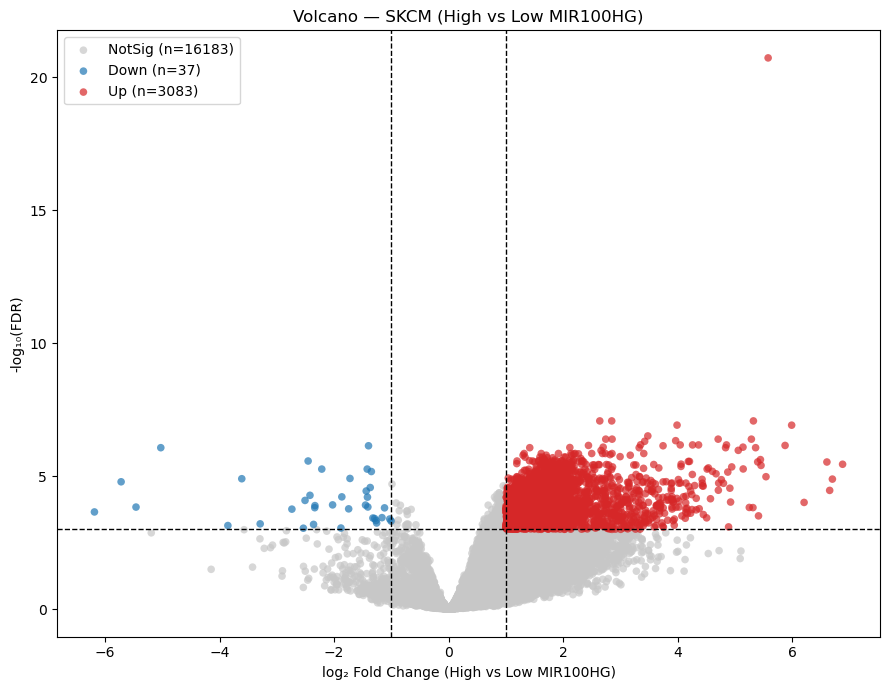

In [27]:
import matplotlib.pyplot as plt

DOT_SIZE = 30  

order = ["NotSig", "Down", "Up"]  
palette = {"NotSig":"#c7c7c7", "Up":"#d62728", "Down":"#1f77b4"}

plt.figure(figsize=(9,7))
for cat in order:
    sub = dea[dea["Category"] == cat]
    plt.scatter(sub["logFC"], sub["neg_log10_FDR"],
                s=DOT_SIZE, alpha=0.7, label=f"{cat} (n={len(sub)})",
                c=palette.get(cat, "#999999"), edgecolors="none")

plt.axvline(logfc_thr,  linestyle="--", linewidth=1, color="black")
plt.axvline(-logfc_thr, linestyle="--", linewidth=1, color="black")
plt.axhline(-np.log10(fdr_thr), linestyle="--", linewidth=1, color="black")

plt.xlabel("log₂ Fold Change (High vs Low MIR100HG)")
plt.ylabel("-log₁₀(FDR)")
plt.title("Volcano — SKCM (High vs Low MIR100HG)")
plt.legend(frameon=True)
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(figdir, f"{dea_prefix}_volcano.png"), dpi=FIG_DPI)
plt.show()


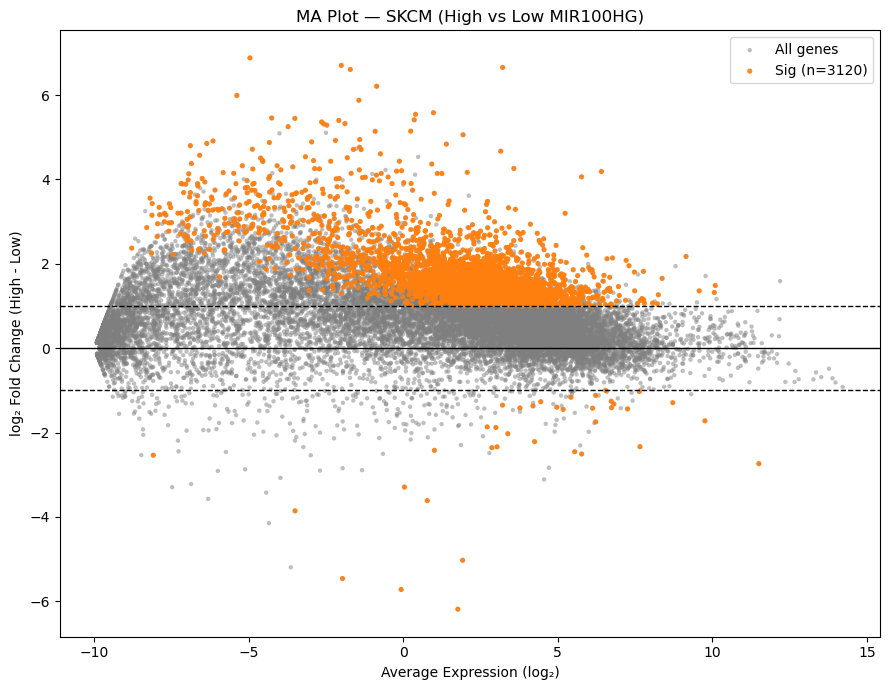

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,7))
plt.scatter(dea["AveExpr"], dea["logFC"], s=10, alpha=0.5,
            c="#7f7f7f", edgecolors="none", label="All genes")

sig = dea[(dea["adj.P.Val"] <= fdr_thr) & (dea["logFC"].abs() >= logfc_thr)]
plt.scatter(sig["AveExpr"], sig["logFC"], s=14, alpha=0.9,
            c="#ff7f0e", edgecolors="none", label=f"Sig (n={len(sig)})")

plt.axhline(0, color="black", linewidth=1)
plt.axhline(logfc_thr,  color="black", linestyle="--", linewidth=1)
plt.axhline(-logfc_thr, color="black", linestyle="--", linewidth=1)
plt.xlabel("Average Expression (log₂)")
plt.ylabel("log₂ Fold Change (High - Low)")
plt.title("MA Plot — SKCM (High vs Low MIR100HG)")
plt.legend(frameon=True)
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(figdir, f"{dea_prefix}_MA.png"), dpi=FIG_DPI)
plt.show()


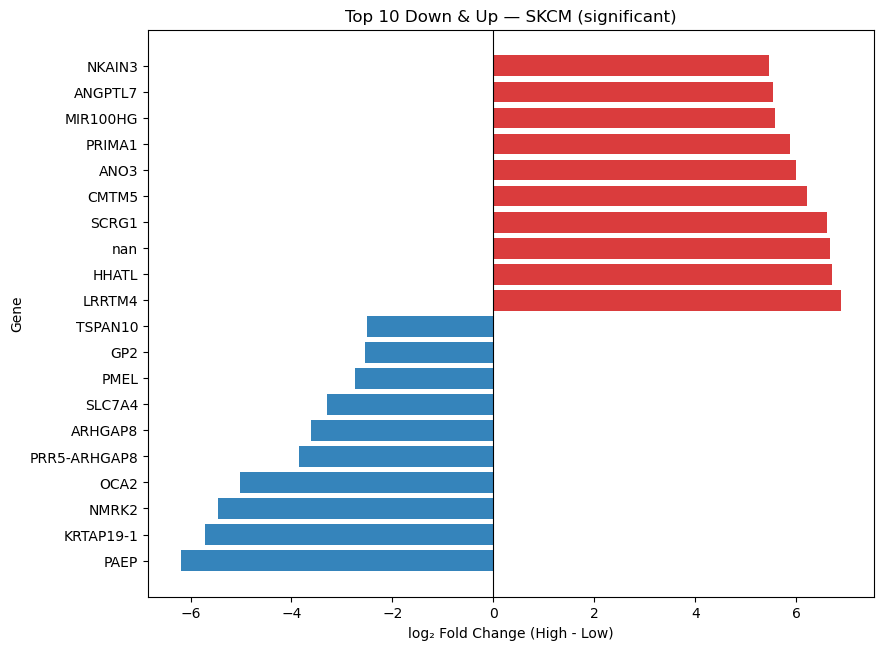

In [31]:
import matplotlib.pyplot as plt
import numpy as np

sig = dea[(dea["adj.P.Val"] <= fdr_thr) & (dea["logFC"].abs() >= logfc_thr)].copy()

n_each = min(10, max(0, len(sig)//2)) if len(sig) < 20 else 10

top_up   = sig.sort_values("logFC", ascending=False).head(n_each).copy()
top_down = sig.sort_values("logFC", ascending=True).head(n_each).copy()
top_both = pd.concat([top_down, top_up], axis=0)

labels_top = gene_label.loc[top_both.index].astype(str)
colors = ["#1f77b4" if v < 0 else "#d62728" for v in top_both["logFC"]]

fig, ax = plt.subplots(figsize=(11,7))
ax.barh(labels_top, top_both["logFC"], alpha=0.9, color=colors)
ax.axvline(0, color="black", linewidth=0.8)
ax.set_xlabel("log₂ Fold Change (High - Low)")
ax.set_ylabel("Gene")
ax.set_title("Top 10 Down & Up — SKCM (significant)")

fig.subplots_adjust(left=0.32, right=0.98, top=0.92)

if SAVE_FIGS:
    plt.savefig(os.path.join(figdir, f"{dea_prefix}_top_genes_barh.png"), dpi=FIG_DPI)
plt.show()


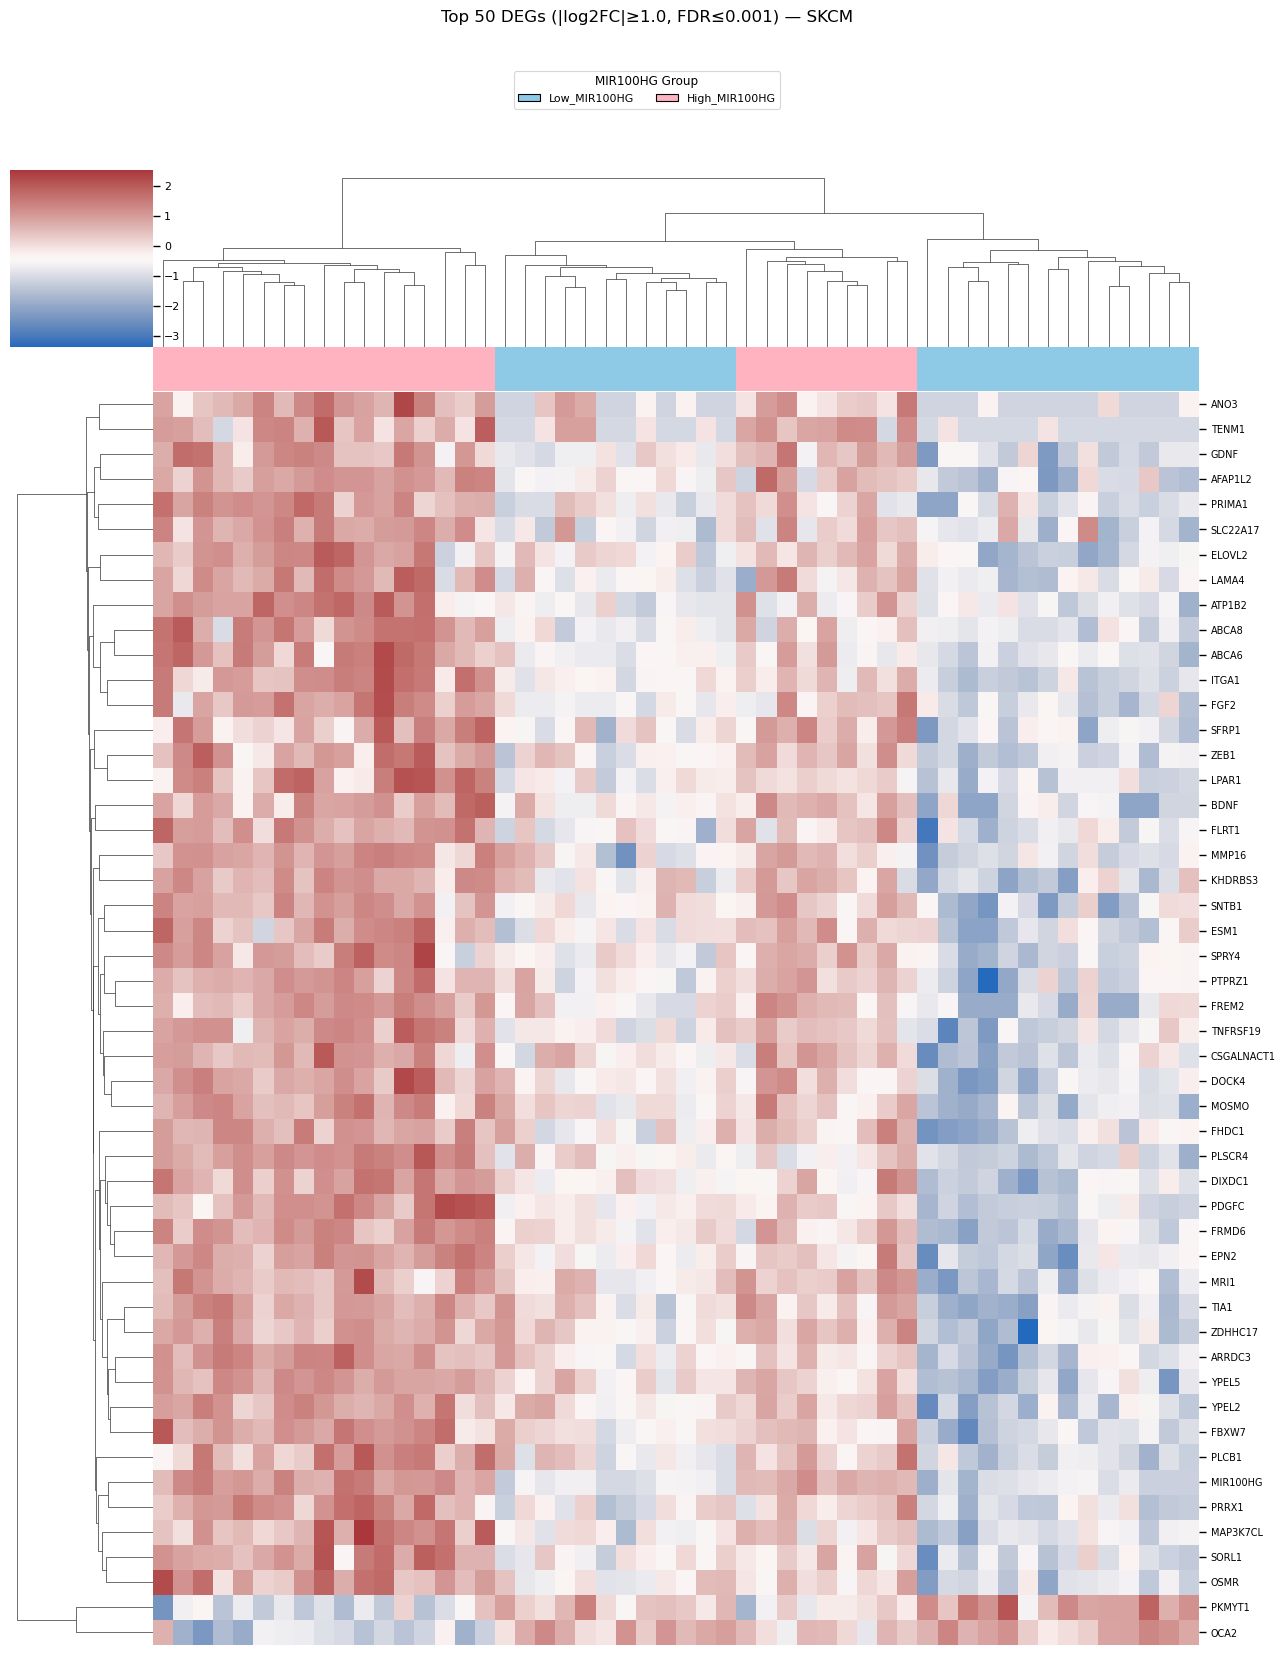

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 9,
})
sns.set_context("paper", font_scale=0.9)

expr_df = pd.read_csv(expr_path, low_memory=False)
if not {"gene_ID","HGNC_symbol","biotype"}.issubset(expr_df.columns):
    raise ValueError("Expression file missing required columns: gene_ID, HGNC_symbol, biotype")

expr_df = expr_df.set_index("gene_ID")
symbol_map = expr_df["HGNC_symbol"].copy()
expr_df = expr_df.drop(columns=["HGNC_symbol", "biotype"])
expr = expr_df.apply(pd.to_numeric, errors="coerce")

info = pd.read_csv(strat_path)
if "MIR100HG_Group" not in info.columns:
    raise ValueError("Stratification file must contain MIR100HG_Group column.")
info = info[info["MIR100HG_Group"].isin(["High_MIR100HG", "Low_MIR100HG"])].copy()

sample_cols_in_info = [c for c in info.columns if info[c].isin(expr.columns).any()]
if not sample_cols_in_info:
    raise ValueError("Could not find a sample ID column in stratification that matches expression columns.")
sample_col = sample_cols_in_info[0]

common_samples = [s for s in info[sample_col] if s in expr.columns]
if len(common_samples) == 0:
    raise ValueError("No overlapping samples between expression matrix and stratification file.")

info = info.set_index(sample_col).loc[common_samples]
ordered_cols = list(info.index[info["MIR100HG_Group"].eq("Low_MIR100HG")]) + \
               list(info.index[info["MIR100HG_Group"].eq("High_MIR100HG")])
expr = expr[ordered_cols]
info = info.loc[ordered_cols].reset_index().rename(columns={"index": "Sample_ID", sample_col: "Sample_ID"})


top_sig = dea[(dea["adj.P.Val"] <= fdr_thr) & (dea["logFC"].abs() >= logfc_thr)].copy()
TOP_N = min(TOP_N_HEATMAP, len(top_sig)) if "TOP_N_HEATMAP" in globals() else min(50, len(top_sig))
top_sig = top_sig.sort_values(["adj.P.Val", "logFC"], ascending=[True, False]).head(TOP_N)

top_genes = [g for g in top_sig.index if g in expr.index]
if len(top_genes) == 0:
    raise ValueError("Selected DEGs are not in the expression matrix index. Check gene IDs/versions.")

heat = expr.loc[top_genes]

sym = symbol_map.reindex(heat.index).fillna("")
row_labels = [s if isinstance(s, str) and len(s) > 0 else gid for gid, s in sym.items()]
heat.index = row_labels

heat_z = heat.sub(heat.mean(axis=1), axis=0)
std = heat.std(axis=1).replace(0, np.nan)
heat_z = heat_z.div(std, axis=0).fillna(0.0)

group_palette = {"Low_MIR100HG": "#8ecae6", "High_MIR100HG": "#ffb3c1"}
group_series = pd.Series(info["MIR100HG_Group"].values, index=expr.columns)
col_colors = group_series.reindex(heat_z.columns).map(group_palette).fillna("#dddddd").tolist()

cohort_label = "SKCM"
try:
    up = dea_prefix.upper()
    if   "PAAD"  in up: cohort_label = "PAAD"
    elif "LUAD"  in up: cohort_label = "LUAD"
    elif "SKCM"  in up: cohort_label = "SKCM"
    elif "GTEX"  in up: cohort_label = "GTEx"
except Exception:
    pass

g = sns.clustermap(
    heat_z, cmap="vlag", col_colors=col_colors,
    figsize=(13, 16), xticklabels=False, yticklabels=True,
    dendrogram_ratio=(0.12, 0.12), cbar_pos=(0.02, 0.82, 0.02, 0.12),
    metric="euclidean", method="average",
    col_cluster=True, row_cluster=True
)

plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=7, rotation=0)
g.ax_heatmap.set_ylabel("")

handles = [Patch(facecolor=c, edgecolor="k", label=lab) for lab, c in group_palette.items()]
g.fig.legend(handles=handles, title="MIR100HG Group",
             loc="upper center", bbox_to_anchor=(0.5, 0.995), ncol=2, frameon=True)

g.fig.suptitle(
    f"Top {len(top_genes)} DEGs (|log2FC|≥{logfc_thr}, FDR≤{fdr_thr}) — {cohort_label}",
    y=1.03, fontsize=12
)
g.fig.subplots_adjust(top=0.93)

if SAVE_FIGS:
    g.savefig(os.path.join(figdir, f"{dea_prefix}_heatmap_top{len(top_genes)}.png"),
              dpi=FIG_DPI, bbox_inches="tight")
plt.show()


# DEA Visualization for Normal(GTEx) gene

In [35]:
import os
import numpy as np
import pandas as pd

outdir = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM"
dea_prefix = "DEA_GTEX_Skin_Normal_High_vs_Low" 

expr_path  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/filtered_expression_protein_coding_plus_MIR100HG_GTEX_skin.csv"
strat_path = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/GTEX_skin_MIR100HG_top25_bottom25_stratification.csv"

logfc_thr = 1.0
fdr_thr   = 0.001
TOP_N_HEATMAP = 50
FIG_DPI = 300
SAVE_FIGS = True

figdir = os.path.join(outdir, "figs_normal")
os.makedirs(figdir, exist_ok=True)

dea_path = os.path.join(outdir, f"{dea_prefix}_full_results.tsv")
dea = pd.read_csv(dea_path, sep="\t", index_col=0)

required_cols = {"logFC", "AveExpr", "P.Value", "adj.P.Val"}
missing = required_cols - set(dea.columns)
if missing:
    raise ValueError(f"Missing columns in DEA table: {missing}")

dea["neg_log10_FDR"] = -np.log10(dea["adj.P.Val"].clip(lower=np.finfo(float).tiny))

def _cat(row):
    if row["adj.P.Val"] <= fdr_thr and row["logFC"] >=  logfc_thr:  return "Up"
    if row["adj.P.Val"] <= fdr_thr and row["logFC"] <= -logfc_thr:  return "Down"
    return "NotSig"

dea["Category"] = dea.apply(_cat, axis=1)

if "HGNC_symbol" in dea.columns:
    gene_label = dea["HGNC_symbol"].astype(str).where(lambda s: s.str.len() > 0, other=dea.index)
else:
    gene_label = pd.Series(dea.index, index=dea.index)


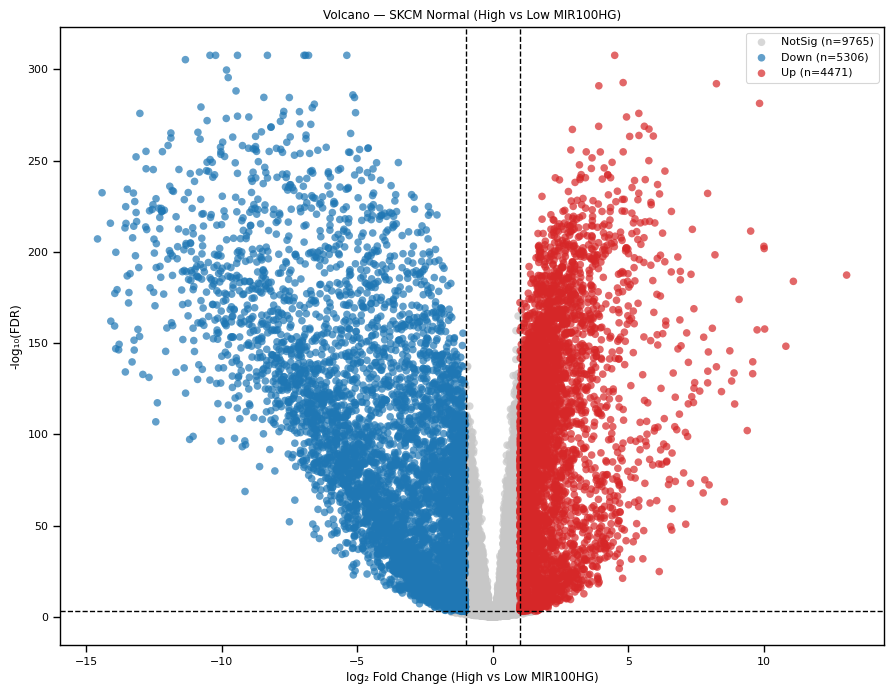

In [37]:

import matplotlib.pyplot as plt

DOT_SIZE = 30  
order = ["NotSig", "Down", "Up"]  # plot NotSig first so others are on top
palette = {"NotSig":"#c7c7c7", "Up":"#d62728", "Down":"#1f77b4"}

plt.figure(figsize=(9,7))
for cat in order:
    sub = dea[dea["Category"] == cat]
    plt.scatter(sub["logFC"], sub["neg_log10_FDR"],
                s=DOT_SIZE, alpha=0.7, label=f"{cat} (n={len(sub)})",
                c=palette.get(cat, "#999999"), edgecolors="none")

# Threshold lines
plt.axvline(logfc_thr,  linestyle="--", linewidth=1, color="black")
plt.axvline(-logfc_thr, linestyle="--", linewidth=1, color="black")
plt.axhline(-np.log10(fdr_thr), linestyle="--", linewidth=1, color="black")

plt.xlabel("log₂ Fold Change (High vs Low MIR100HG)")
plt.ylabel("-log₁₀(FDR)")
plt.title("Volcano — SKCM Normal (High vs Low MIR100HG)")
plt.legend(frameon=True)
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(figdir, f"{dea_prefix}_volcano.png"), dpi=FIG_DPI)
plt.show()

# Step 5 : TF → MIR100HG → Gene Network Construction

[INFO] TFs available for MIR: 57 | TFs shown: 10
[INFO] TFs available for MIR: 57 | TFs shown: 10


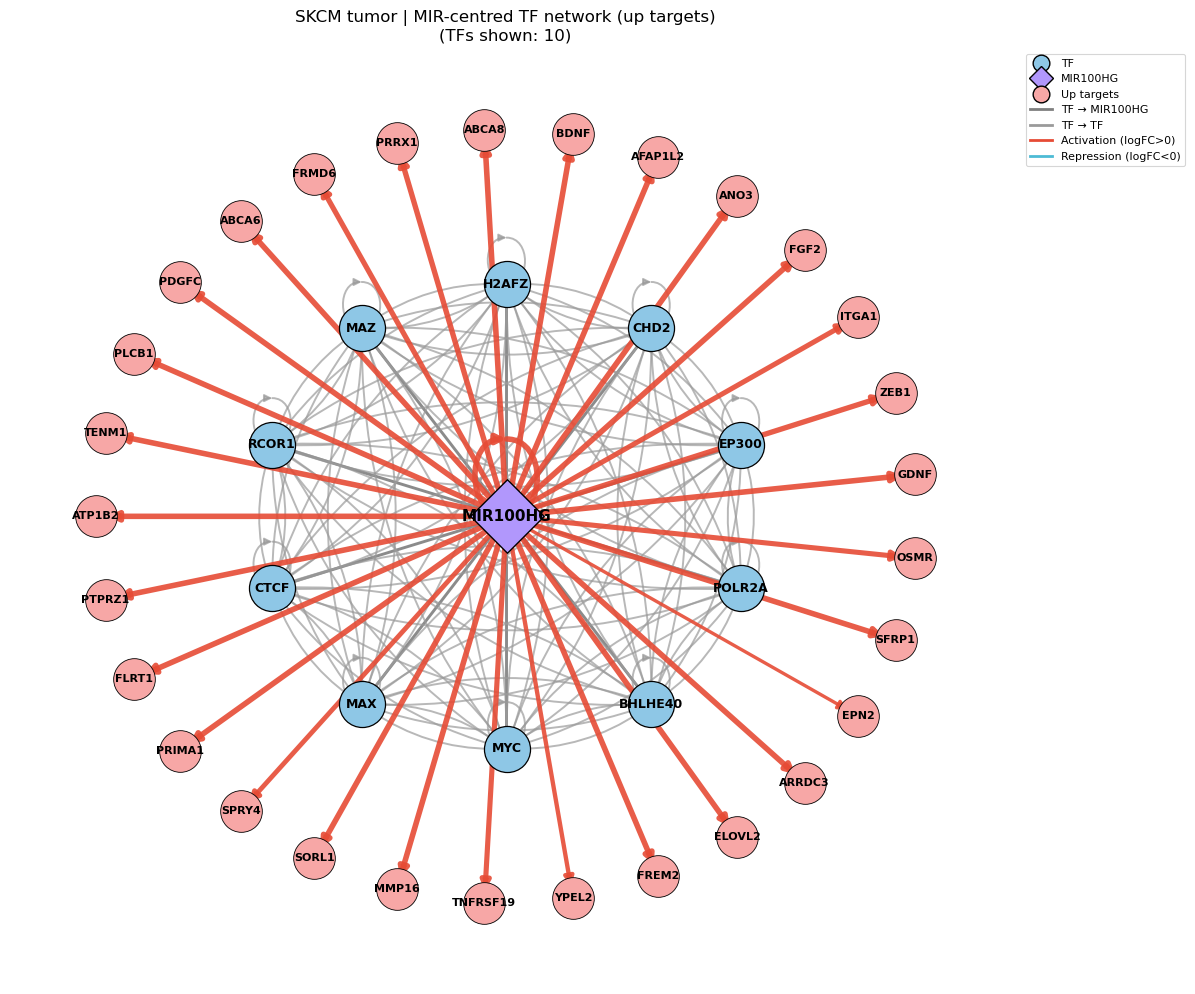

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/SKCM_UP_spider_readableTFs.png


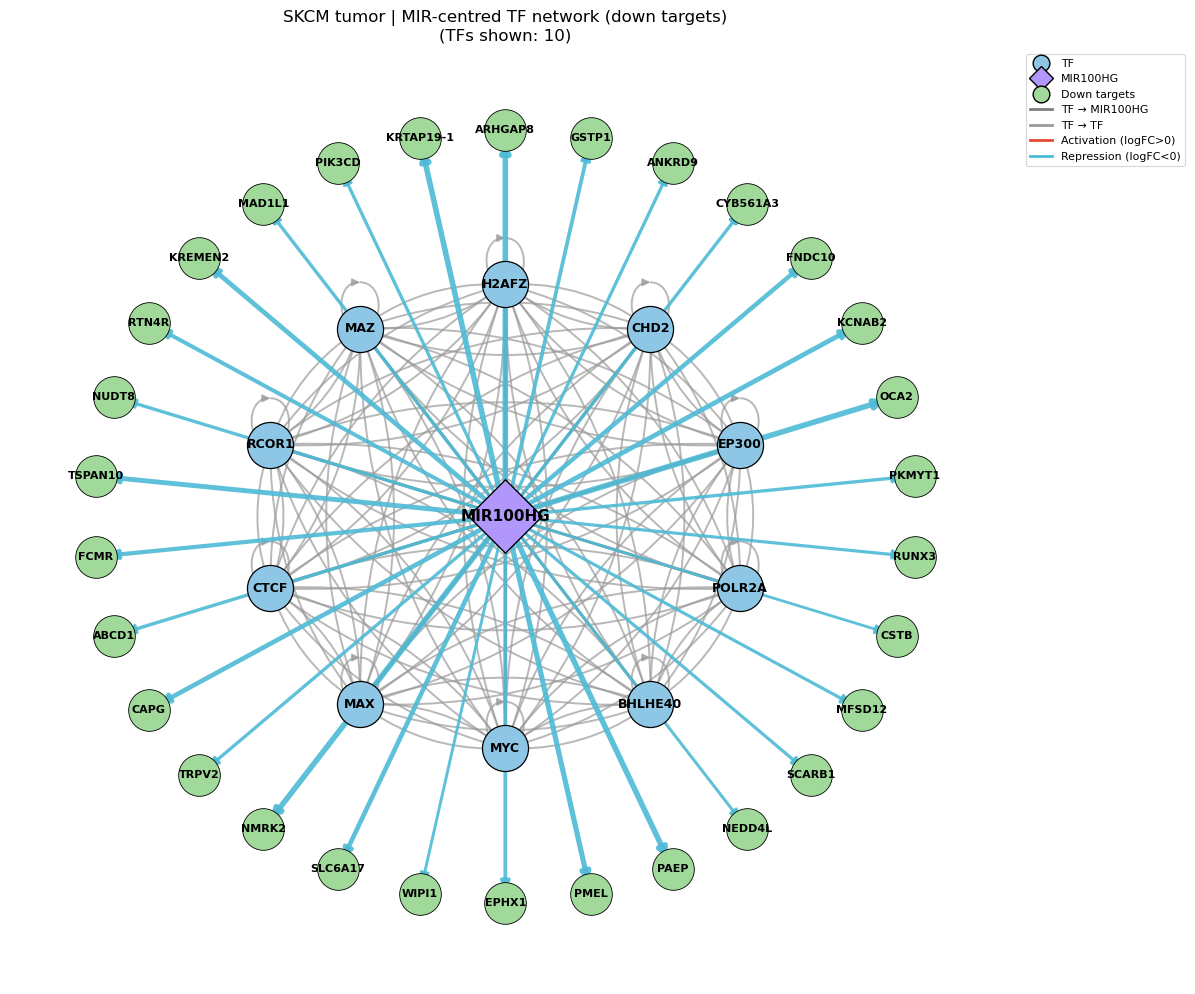

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/SKCM_DOWN_spider_readableTFs.png


In [39]:

import os, re, math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

dea_path      = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/DEA_SKCM_Tumor_High_vs_Low_full_results.tsv"
tf_edges_path = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/gene_attribute_edges.txt"
outdir        = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output"

MIR_SYMBOL = "MIR100HG"
FDR_CUTOFF = 0.001
LFC_CUTOFF = 1.0
N_SHOW_UP   = 30
N_SHOW_DOWN = 30
N_TF_SHOW   = 10     
SEED        = 7

dea = pd.read_csv(dea_path, sep="\t")
sym_col = next((c for c in ["HGNC_symbol","Symbol","gene_symbol","Gene","gene_ID"] if c in dea.columns), None)
if sym_col is None:
    if "Unnamed: 0" in dea.columns:
        dea.rename(columns={"Unnamed: 0":"gene_ID"}, inplace=True)
        sym_col = "gene_ID"
    else:
        dea["gene_ID"] = dea.index.astype(str); sym_col = "gene_ID"
dea["label"] = dea[sym_col].astype(str)

sig = dea[(dea["adj.P.Val"] <= FDR_CUTOFF) & (dea["logFC"].abs() >= LFC_CUTOFF)].copy()
up_all   = sig[sig["logFC"] >=  LFC_CUTOFF].sort_values(["adj.P.Val","logFC"], ascending=[True, False])
down_all = sig[sig["logFC"] <= -LFC_CUTOFF].sort_values(["adj.P.Val","logFC"], ascending=[True, True])


def load_tf_db(path):
    try:
        df = pd.read_csv(path, sep=None, engine="python")
    except Exception:
        df = pd.read_csv(path, sep="\t")
    df.columns = [re.sub(r"\s+", "_", c.strip()) for c in df.columns]
    df.columns = [c.lower() for c in df.columns]
    if "targetgene" in df.columns:
        df = df[~df["targetgene"].astype(str).str.lower().eq("targetgene")]
    need = {"targetgene","transcriptionfactor"}
    if not need.issubset(df.columns):
        raise ValueError("TF table must have columns 'targetGene' and 'TranscriptionFactor'.")
    df = df.dropna(subset=list(need)).copy()
    df["targetgene"] = df["targetgene"].astype(str).str.strip()
    df["transcriptionfactor"] = df["transcriptionfactor"].astype(str).str.strip()
    if "weight" not in df.columns:
        df["weight"] = 1.0
    return df.rename(columns={"targetgene":"target","transcriptionfactor":"tf"})

tfdb = load_tf_db(tf_edges_path)


def rank_tfs_for_plot(tf_set, tfdb, max_n):
    """Rank TFs by TF→TF out-degree within tf_set (then alphabetical), keep top max_n."""
    if not tf_set:
        return []
    tf_tf = tfdb[(tfdb["tf"].isin(tf_set)) & (tfdb["target"].isin(tf_set))][["tf","target"]]
    if tf_tf.empty:
        ranked = sorted(list(tf_set))
    else:
        outdeg = tf_tf.groupby("tf")["target"].nunique()
        ranked = sorted(list(tf_set), key=lambda t: (-outdeg.get(t,0), t))
    return ranked[:max_n]

def build_twohop(direction="up", n_show_targets=30, n_show_tfs=10):
    subset = (up_all if direction=="up" else down_all).head(n_show_targets).copy()

    tf_to_mir = tfdb[tfdb["target"].str.upper() == MIR_SYMBOL.upper()].copy()
    tf_to_mir["weight"] = pd.to_numeric(tf_to_mir["weight"], errors="coerce").fillna(1.0)
    tfs_all = set(tf_to_mir["tf"].unique())

    tfs_show_list = rank_tfs_for_plot(tfs_all, tfdb, n_show_tfs)
    tfs_show = set(tfs_show_list)
    assert len(tfs_show) <= n_show_tfs

    e_tf_mir_all = pd.DataFrame({"source": list(tfs_all), "target": MIR_SYMBOL, "etype": "TF_to_MIR"})
    e_mir_gene_all = subset.assign(source=MIR_SYMBOL, target=subset["label"], etype="MIR_to_gene",
                                   regulation=np.where(subset["logFC"]>0,"activation","repression"),
                                   weight=subset["logFC"].abs()
                                   )[["source","target","etype","regulation","weight","logFC","adj.P.Val"]]
    e_tf_tf_all = tfdb[(tfdb["tf"].isin(tfs_all)) & (tfdb["target"].isin(tfs_all))][["tf","target"]].drop_duplicates()
    if not e_tf_tf_all.empty:
        e_tf_tf_all = e_tf_tf_all.rename(columns={"tf":"source"}).assign(etype="TF_to_TF")

    e_tf_mir = e_tf_mir_all[e_tf_mir_all["source"].isin(tfs_show)].copy()
    e_tf_tf  = (
        e_tf_tf_all[
            e_tf_tf_all["source"].isin(tfs_show) &
            e_tf_tf_all["target"].isin(tfs_show)
        ].copy()
        if not e_tf_tf_all.empty else
        pd.DataFrame(columns=["source","target","etype"])
    )

    e_mir_gene = e_mir_gene_all.copy()
    edges_show = pd.concat([e_tf_mir, e_mir_gene, e_tf_tf], ignore_index=True)

    nodes = pd.DataFrame(pd.unique(edges_show[["source","target"]].values.ravel("K")), columns=["node"])

    nodes["type"] = np.where(nodes["node"]==MIR_SYMBOL, "lncRNA",
                      np.where(nodes["node"].isin(tfs_show), "TF", "gene"))

    dir_map = {r["label"]: ("up" if r["logFC"]>0 else "down") for _, r in subset.iterrows()}
    nodes["direction"] = nodes["node"].map(dir_map).fillna("NA")

    print(f"[INFO] TFs available for MIR: {len(tfs_all)} | TFs shown: {len(tfs_show)}")
    return edges_show, nodes, tfs_show_list

def radial_layout_with_angles(nodes, center, radius_tf=3.6, radius_gene=6.0):
    pos = {}; ang = {}
    pos[center] = (0.0, 0.0); ang[center] = 0.0
    tf_nodes   = nodes[(nodes["type"]=="TF") & (nodes["node"]!=center)]["node"].tolist()
    gene_nodes = nodes[(nodes["type"]=="gene")]["node"].tolist()

    for ring_nodes, R in [(tf_nodes, radius_tf), (gene_nodes, radius_gene)]:
        if ring_nodes:
            angles = np.linspace(0, 2*np.pi, len(ring_nodes), endpoint=False)
            angles = angles + (np.pi/len(ring_nodes))
            for n, a in zip(ring_nodes, angles):
                pos[n] = (R*np.cos(a), R*np.sin(a))
                ang[n] = a
    return pos, ang

def draw_spider(edges, nodes, direction, out_png, tf_fontsize=9, gene_fontsize=8):
    G = nx.DiGraph()
    for _, r in nodes.iterrows():
        G.add_node(r["node"], ntype=r["type"], direction=r["direction"])
    for _, r in edges.iterrows():
        G.add_edge(r["source"], r["target"], etype=r["etype"], regulation=r.get("regulation",""),
                   weight=float(r.get("weight",1.0)))

    pos, ang = radial_layout_with_angles(nodes, MIR_SYMBOL)

    e_tf_mir = [(u,v) for u,v,d in G.edges(data=True) if d["etype"]=="TF_to_MIR"]
    e_mir_g  = [(u,v) for u,v,d in G.edges(data=True) if d["etype"]=="MIR_to_gene"]
    e_tf_tf  = [(u,v) for u,v,d in G.edges(data=True) if d["etype"]=="TF_to_TF"]

    plt.figure(figsize=(12,10))
    # edges
    nx.draw_networkx_edges(G, pos, edgelist=e_tf_mir, edge_color="#7f7f7f", width=2.1,
                           arrows=True, arrowsize=13, arrowstyle='-|>', alpha=0.9)
    nx.draw_networkx_edges(G, pos, edgelist=e_tf_tf, edge_color="#9a9a9a", width=1.4,
                           arrows=True, arrowsize=11, arrowstyle='-|>', alpha=0.7, connectionstyle="arc3,rad=0.18")
    nx.draw_networkx_edges(
        G, pos, edgelist=e_mir_g,
        edge_color=["#E64B35" if G[u][v].get("regulation")=="activation" else "#4DBBD5" for u,v in e_mir_g],
        width=[1.0 + min(3.0, G[u][v].get("weight",1.0)) for u,v in e_mir_g],
        arrows=True, arrowsize=13, arrowstyle='-|>', alpha=0.9
    )

    tf_nodes   = [n for n,d in G.nodes(data=True) if d["ntype"]=="TF"]
    gene_nodes = [n for n,d in G.nodes(data=True) if d["ntype"]=="gene"]
    nx.draw_networkx_nodes(G, pos, nodelist=[MIR_SYMBOL], node_shape="D", node_color="#B197FC",
                           node_size=1400, edgecolors="k", linewidths=1.0)
    nx.draw_networkx_nodes(G, pos, nodelist=tf_nodes, node_shape="o", node_color="#8EC7E6",
                           node_size=1100, edgecolors="k", linewidths=0.9)
    nx.draw_networkx_nodes(G, pos, nodelist=gene_nodes,
                           node_color=("#F7A7A6" if direction=="up" else "#A1D99B"),
                           node_size=900, edgecolors="k", linewidths=0.6)

    plt.text(pos[MIR_SYMBOL][0], pos[MIR_SYMBOL][1], MIR_SYMBOL, ha='center', va='center',
             fontsize=11, fontweight='bold')
    tf_labels = {n:n for n in tf_nodes}
    nx.draw_networkx_labels(G, pos, labels=tf_labels, font_size=tf_fontsize, font_weight="bold")
  
    gene_labels = {n:n for n in gene_nodes}
    nx.draw_networkx_labels(G, pos, labels=gene_labels, font_size=gene_fontsize, font_weight="bold")

    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0],[0], marker='o', color='w', label='TF', markerfacecolor="#8EC7E6", markeredgecolor="k", markersize=12),
        Line2D([0],[0], marker='D', color='w', label='MIR100HG', markerfacecolor="#B197FC", markeredgecolor="k", markersize=12),
        Line2D([0],[0], marker='o', color='w', label=f'{direction.capitalize()} targets',
               markerfacecolor=("#F7A7A6" if direction=="up" else "#A1D99B"), markeredgecolor="k", markersize=12),
        Line2D([0],[0], color="#7f7f7f", lw=2, label='TF → MIR100HG'),
        Line2D([0],[0], color="#9a9a9a", lw=2, label='TF → TF'),
        Line2D([0],[0], color="#E64B35", lw=2, label='Activation (logFC>0)'),
        Line2D([0],[0], color="#4DBBD5", lw=2, label='Repression (logFC<0)'),
    ]
    plt.legend(handles=legend_elems, loc="upper left", bbox_to_anchor=(1.02, 1.0))
    plt.title(f"SKCM tumor | MIR-centred TF network ({direction} targets)\n"
              f"(TFs shown: {len(tf_nodes)})", fontsize=12)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"[WRITE] {out_png}")
edges_up,  nodes_up,  tfs_up  = build_twohop("up",   N_SHOW_UP,   N_TF_SHOW)
edges_dn,  nodes_dn,  tfs_dn  = build_twohop("down", N_SHOW_DOWN, N_TF_SHOW)

draw_spider(edges_up, nodes_up,   "up",   os.path.join(outdir, "SKCM_UP_spider_readableTFs.png"))
draw_spider(edges_dn, nodes_dn,   "down", os.path.join(outdir, "SKCM_DOWN_spider_readableTFs.png"))


# Network For Normal Skin

[INFO] (GTEx skin normal) TFs available: 57 | TFs shown: 10
[INFO] (GTEx skin normal) TFs available: 57 | TFs shown: 10


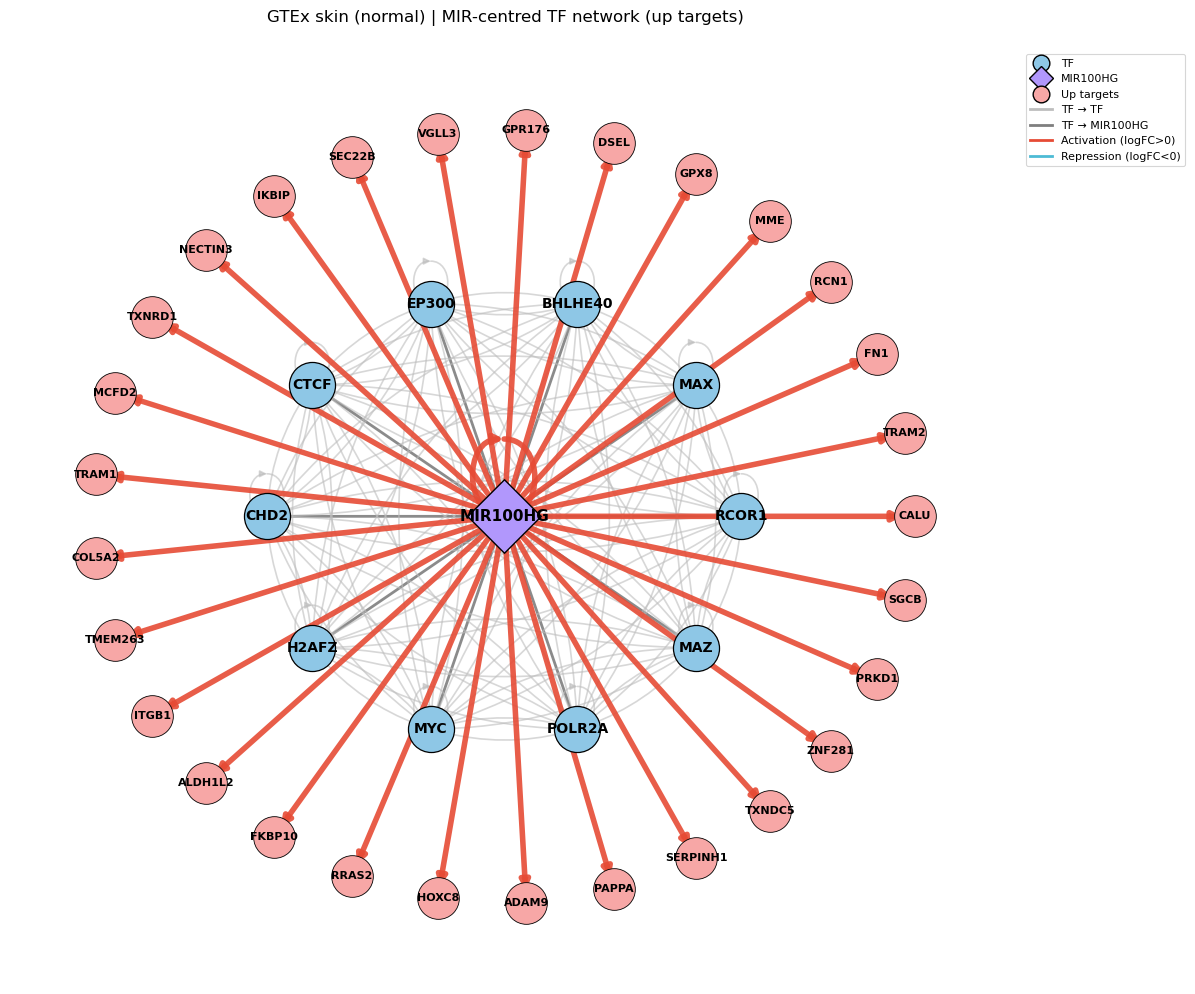

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/GTEX_Skin_NORMAL_UP_spider_readableTFs.png


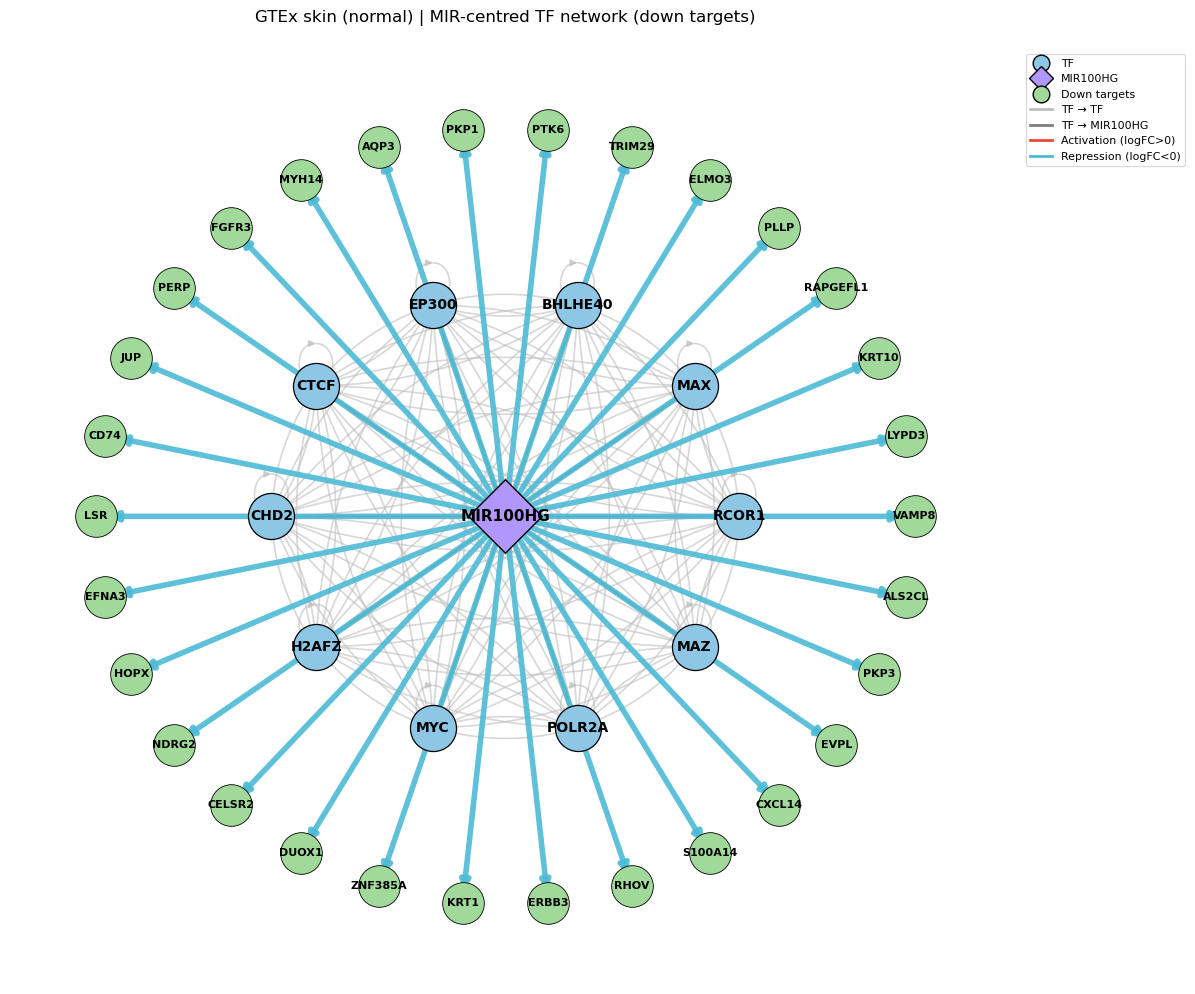

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/GTEX_Skin_NORMAL_DOWN_spider_readableTFs.png


In [41]:
import os, re, math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

dea_path      = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/DEA_GTEX_Skin_Normal_High_vs_Low_full_results.tsv"
tf_edges_path = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/gene_attribute_edges.txt"
outdir        = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM"

MIR_SYMBOL = "MIR100HG"
FDR_CUTOFF = 0.001
LFC_CUTOFF = 1.0
N_SHOW_UP   = 30      
N_SHOW_DOWN = 30      
N_TF_SHOW   = 10     
SEED        = 7

os.makedirs(outdir, exist_ok=True)

dea = pd.read_csv(dea_path, sep="\t")
sym_col = next((c for c in ["HGNC_symbol","Symbol","gene_symbol","Gene","gene_ID"] if c in dea.columns), None)
if sym_col is None:
    if "Unnamed: 0" in dea.columns:
        dea.rename(columns={"Unnamed: 0":"gene_ID"}, inplace=True); sym_col = "gene_ID"
    else:
        dea["gene_ID"] = dea.index.astype(str); sym_col = "gene_ID"
dea["label"] = dea[sym_col].astype(str)

sig = dea[(dea["adj.P.Val"] <= FDR_CUTOFF) & (dea["logFC"].abs() >= LFC_CUTOFF)].copy()
up_all   = sig[sig["logFC"] >=  LFC_CUTOFF].sort_values(["adj.P.Val","logFC"], ascending=[True, False])
down_all = sig[sig["logFC"] <= -LFC_CUTOFF].sort_values(["adj.P.Val","logFC"], ascending=[True, True])

def load_tf_db(path):
    try:
        df = pd.read_csv(path, sep=None, engine="python")
    except Exception:
        df = pd.read_csv(path, sep="\t")
    df.columns = [re.sub(r"\s+", "_", str(c).strip()) for c in df.columns]
    df.columns = [c.lower() for c in df.columns]

    if "targetgene" in df.columns:
        df = df[~df["targetgene"].astype(str).str.lower().eq("targetgene")]

    need = {"targetgene","transcriptionfactor"}
    if not need.issubset(df.columns):
        raise ValueError("TF table must have columns 'targetGene' and 'TranscriptionFactor'.")

    df["targetgene"] = df["targetgene"].astype(str).str.strip()
    df["transcriptionfactor"] = df["transcriptionfactor"].astype(str).str.strip()

    bad_tokens = {"na","nan","","tf_id","tg_id","weight"}
    num_re = re.compile(r"^[+-]?\d+(?:\.\d+)?$")
    def good(x):
        s = str(x).strip().lower()
        return (s not in bad_tokens) and (not num_re.match(s))
    df = df[df["targetgene"].map(good) & df["transcriptionfactor"].map(good)].copy()

    if "weight" not in df.columns:
        df["weight"] = 1.0

    out = df.rename(columns={"targetgene":"target","transcriptionfactor":"tf"})[["tf","target","weight"]].copy()
    out["tf"] = out["tf"].astype(str)
    out["target"] = out["target"].astype(str)
    return out

tfdb = load_tf_db(tf_edges_path)

def rank_tfs_for_plot(tf_set, tfdb, max_n):
    """Rank TFs by TF→TF out-degree within tf_set (hubbiest first), then alphabetical."""
    if not tf_set:
        return []
    tf_tf = tfdb[(tfdb["tf"].isin(tf_set)) & (tfdb["target"].isin(tf_set))][["tf","target"]]
    if tf_tf.empty:
        ranked = sorted(tf_set)
    else:
        outdeg = tf_tf.groupby("tf")["target"].nunique()
        ranked = sorted(tf_set, key=lambda t: (-outdeg.get(t,0), t))
    return ranked[:max_n]

def build_twohop(direction="up", n_show_targets=30, n_show_tfs=10):
    subset = (up_all if direction=="up" else down_all).head(n_show_targets).copy()

    tf_to_mir = tfdb[tfdb["target"].str.upper() == MIR_SYMBOL.upper()].copy()
    tf_to_mir["weight"] = pd.to_numeric(tf_to_mir["weight"], errors="coerce").fillna(1.0)
    tfs_all = set(tf_to_mir["tf"].unique())
    tfs_show = set(rank_tfs_for_plot(tfs_all, tfdb, n_show_tfs))

    e_tf_mir = pd.DataFrame({"source": list(tfs_show), "target": MIR_SYMBOL, "etype": "TF_to_MIR"})
    e_mir_gene = subset.assign(source=MIR_SYMBOL, target=subset["label"], etype="MIR_to_gene",
                               regulation=np.where(subset["logFC"]>0,"activation","repression"),
                               weight=subset["logFC"].abs()
                               )[["source","target","etype","regulation","weight","logFC","adj.P.Val"]]

    e_tf_tf = tfdb[(tfdb["tf"].isin(tfs_show)) & (tfdb["target"].isin(tfs_show))][["tf","target"]].drop_duplicates()
    if not e_tf_tf.empty:
        e_tf_tf = e_tf_tf.rename(columns={"tf":"source"}).assign(etype="TF_to_TF")

    edges_show = pd.concat([e_tf_mir, e_mir_gene, e_tf_tf], ignore_index=True)

    nodes = pd.DataFrame(pd.unique(edges_show[["source","target"]].values.ravel("K")), columns=["node"])
    tf_universe = set(tfdb["tf"].unique())
    nodes["type"] = np.where(nodes["node"]==MIR_SYMBOL, "lncRNA",
                      np.where(nodes["node"].isin(tfs_show), "TF",
                        np.where(nodes["node"].isin(tf_universe), "TF", "gene")))
    dir_map = {r["label"]: ("up" if r["logFC"]>0 else "down") for _, r in subset.iterrows()}
    nodes["direction"] = nodes["node"].map(dir_map).fillna("NA")

    tag = f"GTEX_Skin_NORMAL_{direction.upper()}_SHOWN_FDR{str(FDR_CUTOFF).replace('.','')}_LFC{int(LFC_CUTOFF)}"
    edges_show.to_csv(os.path.join(outdir, f"{tag}_edges.csv"), index=False)
    nodes.to_csv(os.path.join(outdir, f"{tag}_nodes.csv"), index=False)

    print(f"[INFO] (GTEx skin normal) TFs available: {len(tfs_all)} | TFs shown: {len(tfs_show)}")
    return edges_show, nodes

def radial_layout(nodes, center, base_tf=3.0, base_gene=5.0):
    pos = {center: (0.0, 0.0)}
    tf_nodes   = nodes[(nodes["type"]=="TF") & (nodes["node"]!=center)]["node"].tolist()
    gene_nodes = nodes[(nodes["type"]=="gene")]["node"].tolist()

    R_tf   = base_tf   + 0.10 * max(0, len(tf_nodes) - 8)
    R_gene = base_gene + 0.06 * max(0, len(gene_nodes) - 20)

    for ring_nodes, R in [(tf_nodes, R_tf), (gene_nodes, R_gene)]:
        if ring_nodes:
            angles = np.linspace(0, 2*np.pi, len(ring_nodes), endpoint=False)
            for n, a in zip(ring_nodes, angles):
                pos[n] = (R*np.cos(a), R*np.sin(a))
    return pos

def draw_spider(edges, nodes, direction, out_png,
                tf_fontsize=10, gene_fontsize=8, node_scale=1.0):
    G = nx.DiGraph()
    for _, r in nodes.iterrows():
        G.add_node(str(r["node"]), ntype=r["type"], direction=r["direction"])
    for _, r in edges.iterrows():
        G.add_edge(str(r["source"]), str(r["target"]),
                   etype=r["etype"], regulation=r.get("regulation",""),
                   weight=float(r.get("weight",1.0)))

    pos = radial_layout(nodes, MIR_SYMBOL)

    e_tf_mir = [(u,v) for u,v,d in G.edges(data=True) if d["etype"]=="TF_to_MIR"]
    e_mir_g  = [(u,v) for u,v,d in G.edges(data=True) if d["etype"]=="MIR_to_gene"]
    e_tf_tf  = [(u,v) for u,v,d in G.edges(data=True) if d["etype"]=="TF_to_TF"]

    plt.figure(figsize=(12,10))
    nx.draw_networkx_edges(G, pos, edgelist=e_tf_mir, edge_color="#7f7f7f", width=2.0,
                           arrows=True, arrowsize=13, arrowstyle='-|>', alpha=0.9)
    if e_tf_tf:
        nx.draw_networkx_edges(G, pos, edgelist=e_tf_tf, edge_color="#bdbdbd", width=1.2,
                               arrows=True, arrowsize=10, arrowstyle='-|>', alpha=0.6, connectionstyle="arc3,rad=0.15")
    nx.draw_networkx_edges(
        G, pos, edgelist=e_mir_g,
        edge_color=["#E64B35" if G[u][v].get("regulation")=="activation" else "#4DBBD5" for u,v in e_mir_g],
        width=[1.0 + min(3.0, G[u][v].get("weight",1.0)) for u,v in e_mir_g],
        arrows=True, arrowsize=13, arrowstyle='-|>', alpha=0.9
    )

    tf_nodes   = [n for n,d in G.nodes(data=True) if d["ntype"]=="TF"]
    gene_nodes = [n for n,d in G.nodes(data=True) if d["ntype"]=="gene"]

    nx.draw_networkx_nodes(G, pos, nodelist=[MIR_SYMBOL], node_shape="D", node_color="#B197FC",
                           node_size=1400*node_scale, edgecolors="k", linewidths=1.0)
    nx.draw_networkx_nodes(G, pos, nodelist=tf_nodes, node_shape="o", node_color="#8EC7E6",
                           node_size=1100*node_scale, edgecolors="k", linewidths=0.9)
    nx.draw_networkx_nodes(G, pos, nodelist=gene_nodes,
                           node_color=("#F7A7A6" if direction=="up" else "#A1D99B"),
                           node_size=900*node_scale, edgecolors="k", linewidths=0.6)

    plt.text(pos[MIR_SYMBOL][0], pos[MIR_SYMBOL][1], MIR_SYMBOL, ha='center', va='center',
             fontsize=11, fontweight='bold')
    nx.draw_networkx_labels(G, pos, labels={n:n for n in tf_nodes},
                            font_size=tf_fontsize, font_weight="bold")
    nx.draw_networkx_labels(G, pos, labels={n:n for n in gene_nodes},
                            font_size=gene_fontsize, font_weight="bold")

    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0],[0], marker='o', color='w', label='TF', markerfacecolor="#8EC7E6", markeredgecolor="k", markersize=12),
        Line2D([0],[0], marker='D', color='w', label='MIR100HG', markerfacecolor="#B197FC", markeredgecolor="k", markersize=12),
        Line2D([0],[0], marker='o', color='w', label=f'{direction.capitalize()} targets',
               markerfacecolor=("#F7A7A6" if direction=="up" else "#A1D99B"), markeredgecolor="k", markersize=12),
        Line2D([0],[0], color="#7f7f7f", lw=2, label='TF → MIR100HG'),
        Line2D([0],[0], color="#E64B35", lw=2, label='Activation (logFC>0)'),
        Line2D([0],[0], color="#4DBBD5", lw=2, label='Repression (logFC<0)'),
    ]
    if e_tf_tf:
        legend_elems.insert(3, Line2D([0],[0], color="#bdbdbd", lw=2, label='TF → TF'))

    plt.legend(handles=legend_elems, loc="upper left", bbox_to_anchor=(1.02, 1.0))
    plt.title(f"GTEx skin (normal) | MIR-centred TF network ({direction} targets)\n", fontsize=12)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"[WRITE] {out_png}")

edges_up,  nodes_up  = build_twohop("up",   N_SHOW_UP,   N_TF_SHOW)
edges_dn,  nodes_dn  = build_twohop("down", N_SHOW_DOWN, N_TF_SHOW)

draw_spider(edges_up, nodes_up,   "up",   os.path.join(outdir, "GTEX_Skin_NORMAL_UP_spider_readableTFs.png"))
draw_spider(edges_dn, nodes_dn,   "down", os.path.join(outdir, "GTEX_Skin_NORMAL_DOWN_spider_readableTFs.png"))


In [43]:

import os, pandas as pd

TUMOR_FILE  = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/DEA_SKCM_Tumor_High_vs_Low_full_results.tsv"
NORMAL_FILE = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/DEA_GTEX_Skin_Normal_High_vs_Low_full_results.tsv"
OUTDIR      = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min"
FDR_CUTOFF, LFC_MIN = 0.001, 1.0

os.makedirs(OUTDIR, exist_ok=True)

def _symcol(df):
    for c in ["HGNC_symbol","Symbol","gene_symbol","Gene","gene_ID","Unnamed: 0"]:
        if c in df.columns: return c
    df["gene_ID"] = df.index.astype(str); return "gene_ID"

def _read_dea(path, pref):
    df = pd.read_csv(path, sep="\t")
    sc = _symcol(df); df["Symbol"] = df[sc].astype(str)
    keep = ["Symbol","logFC","adj.P.Val"]; df = df[[c for c in keep if c in df.columns]].drop_duplicates("Symbol")
    return df.rename(columns={"logFC":f"logFC_{pref}","adj.P.Val":f"adj_{pref}"})

tum, norm = _read_dea(TUMOR_FILE,"tum"), _read_dea(NORMAL_FILE,"norm")
merged = tum.merge(norm, on="Symbol", how="outer")

def _call(fc, adj):
    if pd.isna(fc) or pd.isna(adj) or adj>FDR_CUTOFF or abs(fc)<LFC_MIN: return "NS"
    return "UP" if fc>=LFC_MIN else "DOWN"

merged["dir_tum"]  = [_call(r.logFC_tum,  r.adj_tum)  for r in merged.itertuples()]
merged["dir_norm"] = [_call(r.logFC_norm, r.adj_norm) for r in merged.itertuples()]
merged["sig_tum"]  = merged["dir_tum"].ne("NS")
merged["sig_norm"] = merged["dir_norm"].ne("NS")
merged["delta_logFC"] = merged["logFC_tum"] - merged["logFC_norm"]

both_sig = merged[merged.sig_tum & merged.sig_norm]
up_up     = both_sig[(both_sig.dir_tum=="UP")   & (both_sig.dir_norm=="UP")]
up_down   = both_sig[(both_sig.dir_tum=="UP")   & (both_sig.dir_norm=="DOWN")]
down_up   = both_sig[(both_sig.dir_tum=="DOWN") & (both_sig.dir_norm=="UP")]
down_down = both_sig[(both_sig.dir_tum=="DOWN") & (both_sig.dir_norm=="DOWN")]
tum_only  = merged[ merged.sig_tum & ~merged.sig_norm]
norm_only = merged[ merged.sig_norm & ~merged.sig_tum]
concordant = pd.concat([up_up, down_down], ignore_index=True)
discordant = pd.concat([up_down, down_up], ignore_index=True)

def w(df, name): p=os.path.join(OUTDIR,f"{name}.tsv"); df.to_csv(p, sep="\t", index=False); print("[WRITE]",p)
for n,d in [("UP_UP_genes",up_up),("UP_DOWN_genes",up_down),("DOWN_UP_genes",down_up),("DOWN_DOWN_genes",down_down),
            ("Tumour_only_sig",tum_only),("Normal_only_sig",norm_only),
            ("Concordant_both_sig",concordant),("Discordant_both_sig",discordant),
            ("merged_with_calls",merged)]:
    w(d, n)

cont = both_sig.groupby(["dir_tum","dir_norm"]).size().reset_index(name="n")
w(cont,"direction_contingency")
summary = pd.DataFrame({
    "Category": ["UP_UP","UP_DOWN","DOWN_UP","DOWN_DOWN","Tumour_only","Normal_only","Concordant","Discordant"],
    "Count":    [len(up_up),len(up_down),len(down_up),len(down_down),len(tum_only),len(norm_only),len(concordant),len(discordant)]
})
w(summary,"summary_counts")
w(merged[["Symbol","logFC_tum","logFC_norm","delta_logFC"]].dropna(),"delta_logFC_all_genes")

try:
    from IPython.display import display, HTML
    # 1) Overview totals
    totals_df = pd.DataFrame({
        "Metric": ["All genes merged","Significant in tumour","Significant in normal","Significant in both"],
        "Count":  [len(merged), int(merged.sig_tum.sum()), int(merged.sig_norm.sum()), len(both_sig)]
    })
    display(HTML("<h3>Overview totals</h3>"))
    display(totals_df.set_index("Metric"))

    # 2) Direction buckets (counts)
    display(HTML("<h3>Direction buckets (counts)</h3>"))
    display(summary.set_index("Category"))

    # 3) 2×2 direction contingency among BOTH significant genes
    cont_pivot = cont.pivot(index="dir_tum", columns="dir_norm", values="n").fillna(0).astype(int)
    cont_pivot = cont_pivot.reindex(index=["UP","DOWN"], columns=["UP","DOWN"], fill_value=0)
    display(HTML("<h3>2×2 direction contingency (both significant)</h3>"))
    display(cont_pivot)
except Exception:
    print("\n### Overview totals")
    print(totals_df.set_index("Metric"))
    print("\n### Direction buckets (counts)")
    print(summary.set_index("Category"))
    print("\n### 2×2 direction contingency (both significant)")
    cont_pivot = cont.pivot(index="dir_tum", columns="dir_norm", values="n").fillna(0).astype(int)
    cont_pivot = cont_pivot.reindex(index=["UP","DOWN"], columns=["UP","DOWN"], fill_value=0)
    print(cont_pivot)


[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/UP_UP_genes.tsv
[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/UP_DOWN_genes.tsv
[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/DOWN_UP_genes.tsv
[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/DOWN_DOWN_genes.tsv
[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/Tumour_only_sig.tsv
[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/Normal_only_sig.tsv
[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/Concordant_both_sig.tsv
[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/outp

Count
Metric                      
All genes merged       19214
Significant in tumour   3116
Significant in normal   9626
Significant in both     1569

Count
Category          
UP_UP         1122
UP_DOWN        422
DOWN_UP          7
DOWN_DOWN       18
Tumour_only   1547
Normal_only   8057
Concordant    1140
Discordant     429

dir_norm    UP  DOWN
dir_tum             
UP        1122   422
DOWN         7    18

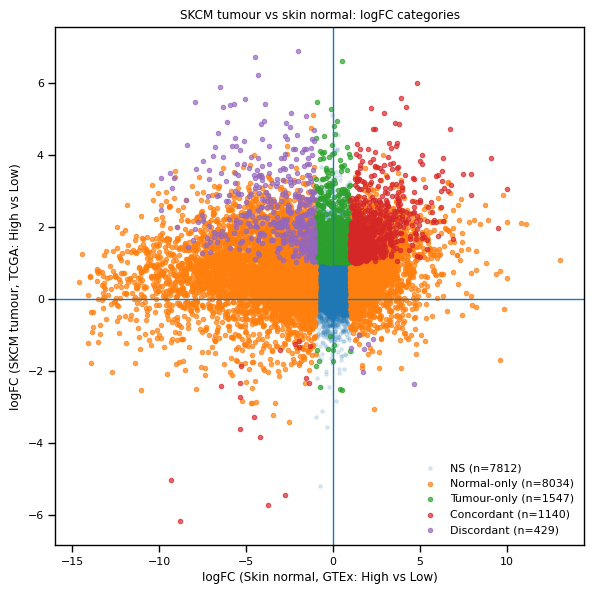

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt

def cat_row(r):
    if r.sig_tum and r.sig_norm:
        return "Concordant" if r.dir_tum == r.dir_norm else "Discordant"
    if r.sig_tum and not r.sig_norm:
        return "Tumour-only"
    if r.sig_norm and not r.sig_tum:
        return "Normal-only"
    return "NS"

merged["cat"] = [cat_row(r) for r in merged.itertuples()]

order  = ["NS","Normal-only","Tumour-only","Concordant","Discordant"]
sizes  = {"NS":6,"Normal-only":10,"Tumour-only":10,"Concordant":10,"Discordant":10}
alphas = {"NS":0.15,"Normal-only":0.7,"Tumour-only":0.7,"Concordant":0.7,"Discordant":0.7}

plt.figure(figsize=(6,6))
for c in order:
    sub = merged[merged["cat"]==c].dropna(subset=["logFC_norm","logFC_tum"])
    plt.scatter(sub["logFC_norm"], sub["logFC_tum"],
                s=sizes[c], alpha=alphas[c], label=f"{c} (n={len(sub)})")

plt.axhline(0, lw=1); plt.axvline(0, lw=1)
plt.xlabel("logFC (Skin normal, GTEx: High vs Low)")
plt.ylabel("logFC (SKCM tumour, TCGA: High vs Low)")
plt.title("SKCM tumour vs skin normal: logFC categories")
plt.legend(frameon=False, loc="best")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "lfc_scatter_categorised.png"), dpi=180)
plt.show()
plt.close()


# Step 7 - Enrichment Analysis

[ENRICH] Concordant_UP_UP (n=1122)


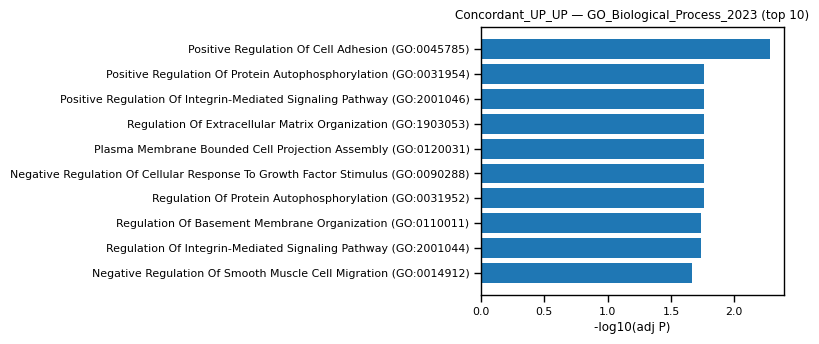

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Concordant_UP_UP_GO_Biological_Process_2023.png


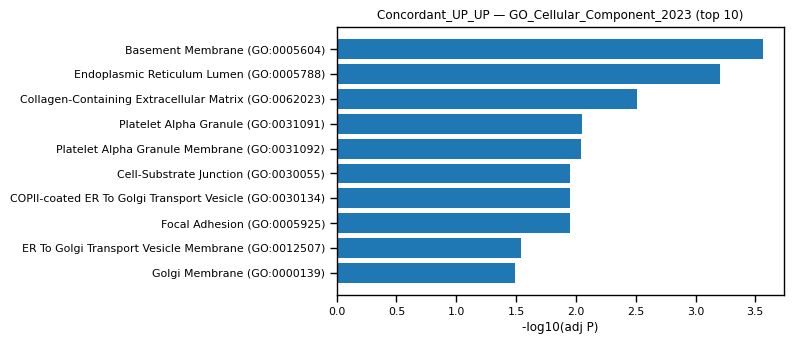

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Concordant_UP_UP_GO_Cellular_Component_2023.png


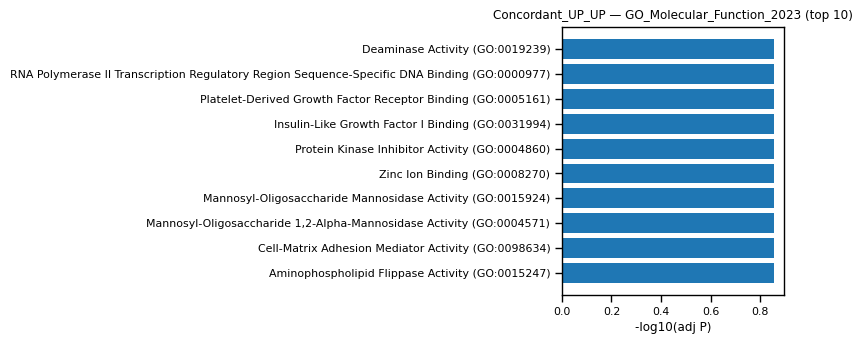

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Concordant_UP_UP_GO_Molecular_Function_2023.png


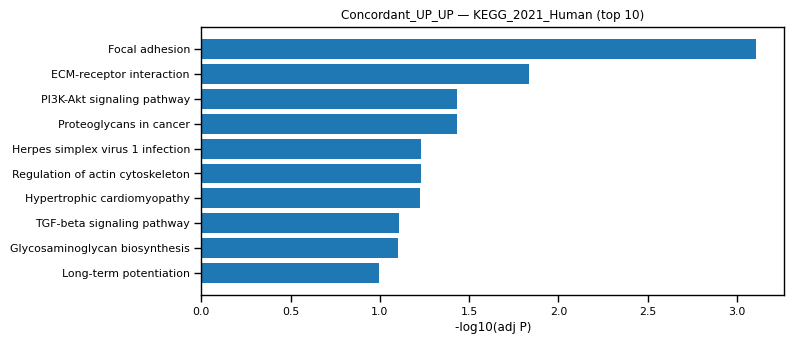

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Concordant_UP_UP_KEGG_2021_Human.png


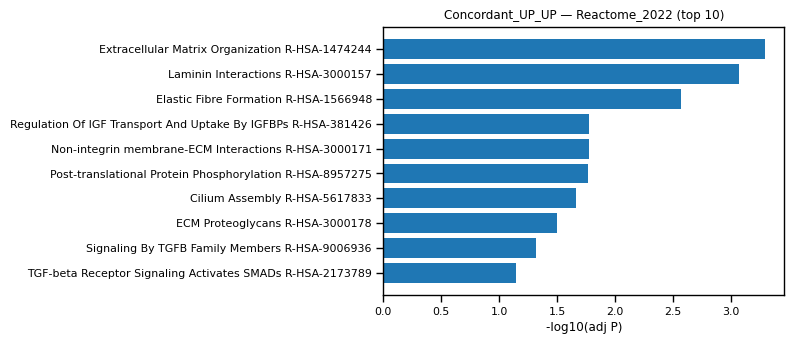

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Concordant_UP_UP_Reactome_2022.png
[ENRICH] Concordant_DOWN_DOWN (n=18)


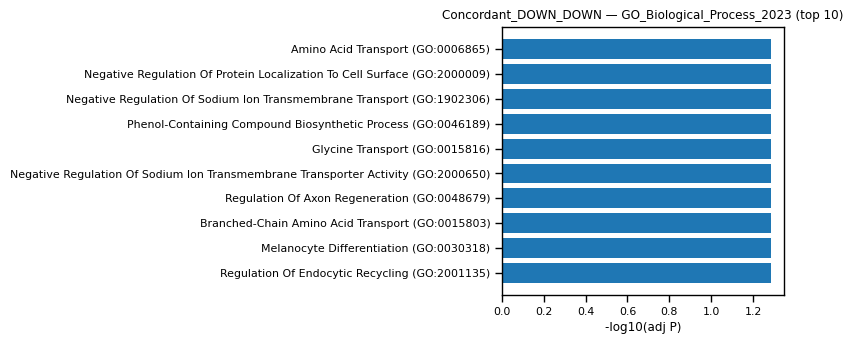

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Concordant_DOWN_DOWN_GO_Biological_Process_2023.png


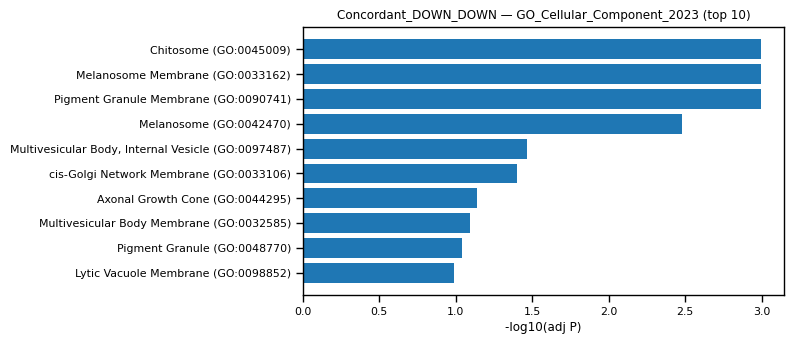

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Concordant_DOWN_DOWN_GO_Cellular_Component_2023.png


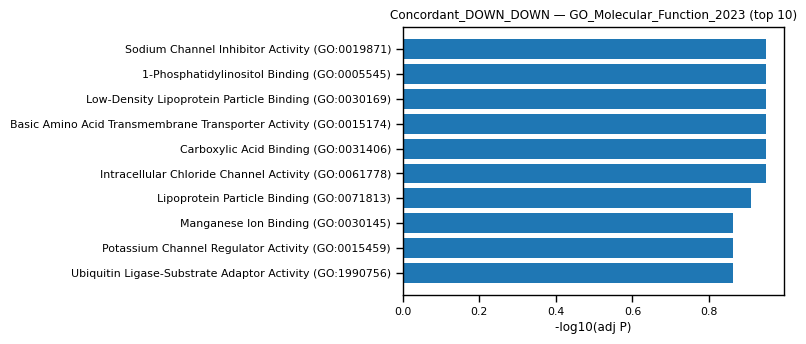

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Concordant_DOWN_DOWN_GO_Molecular_Function_2023.png


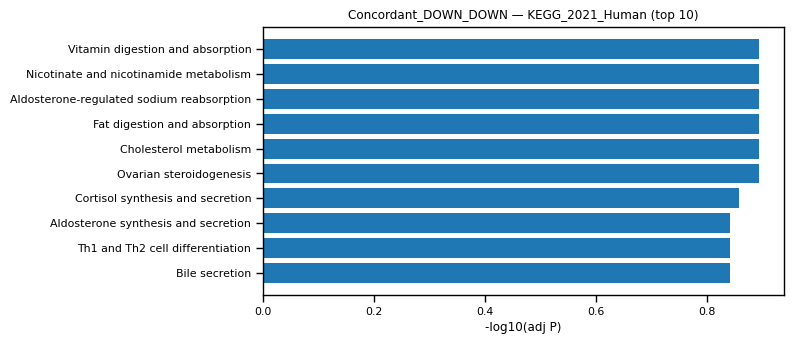

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Concordant_DOWN_DOWN_KEGG_2021_Human.png


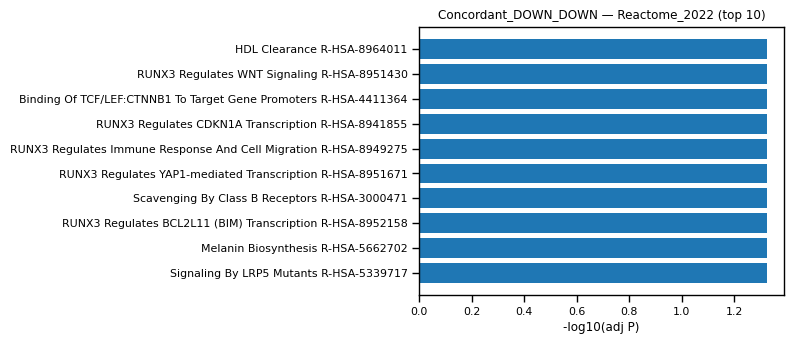

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Concordant_DOWN_DOWN_Reactome_2022.png
[ENRICH] Tumour_only (n=1547)


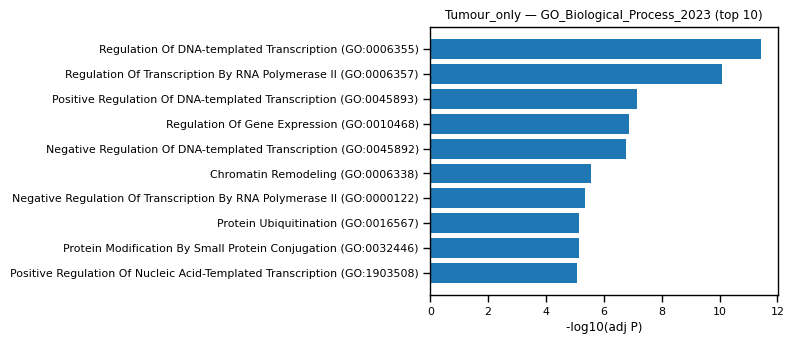

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Tumour_only_GO_Biological_Process_2023.png


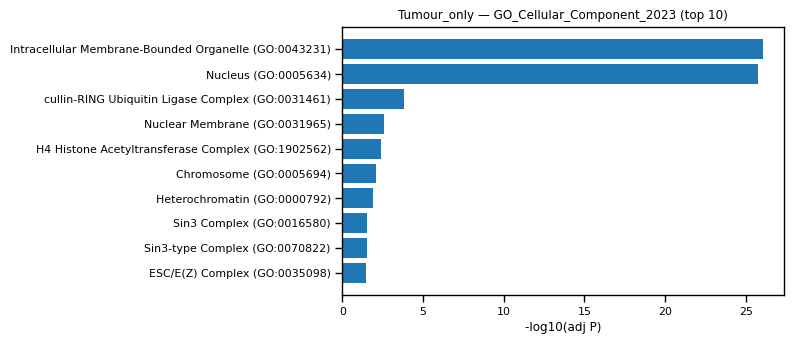

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Tumour_only_GO_Cellular_Component_2023.png


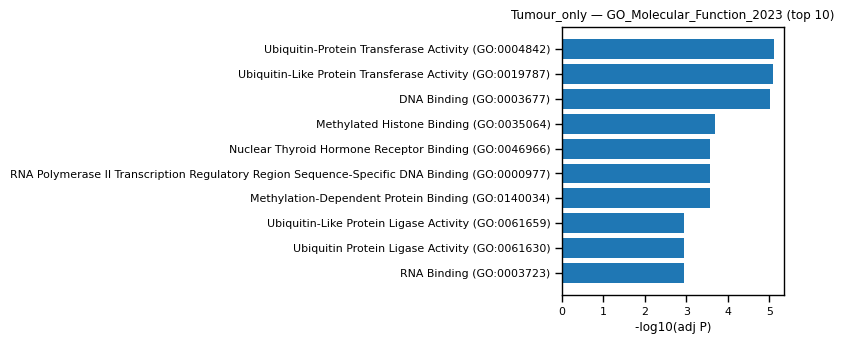

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Tumour_only_GO_Molecular_Function_2023.png


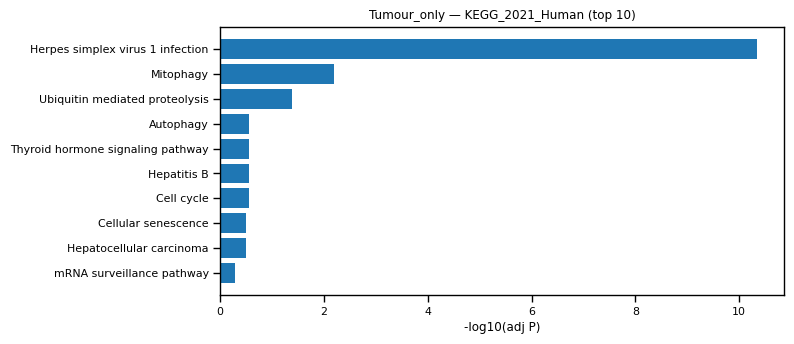

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Tumour_only_KEGG_2021_Human.png


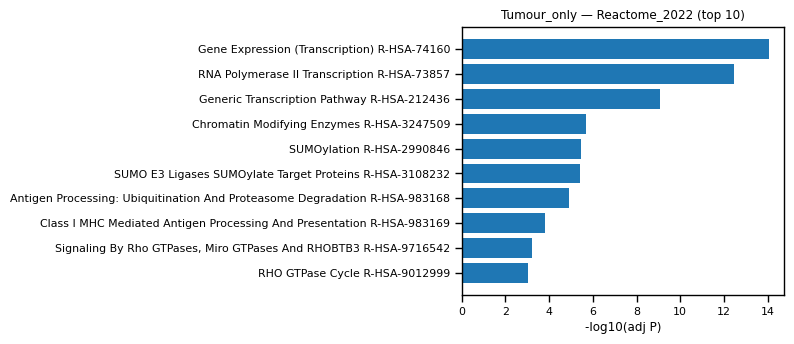

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Tumour_only_Reactome_2022.png
[ENRICH] Normal_only (n=8057)


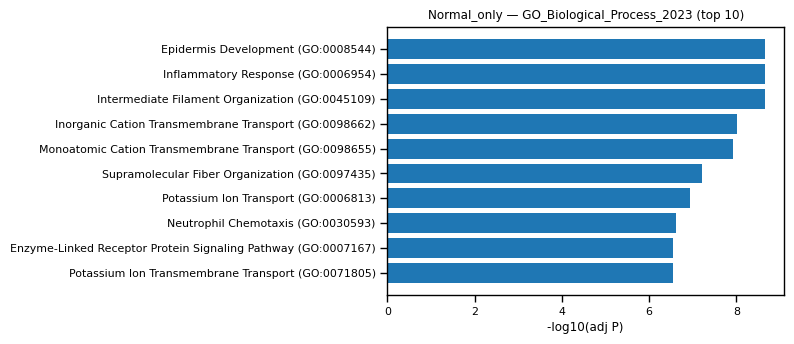

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Normal_only_GO_Biological_Process_2023.png


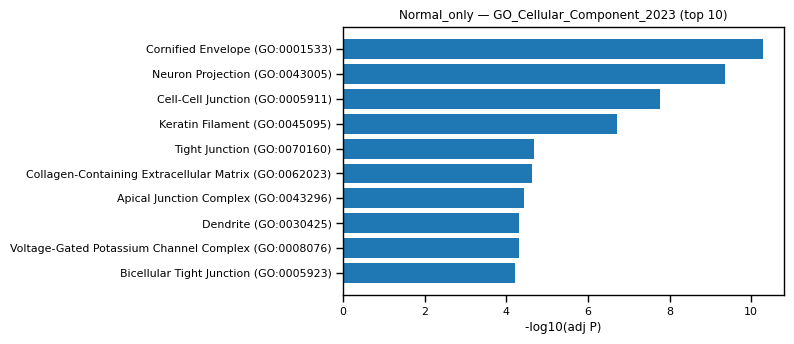

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Normal_only_GO_Cellular_Component_2023.png


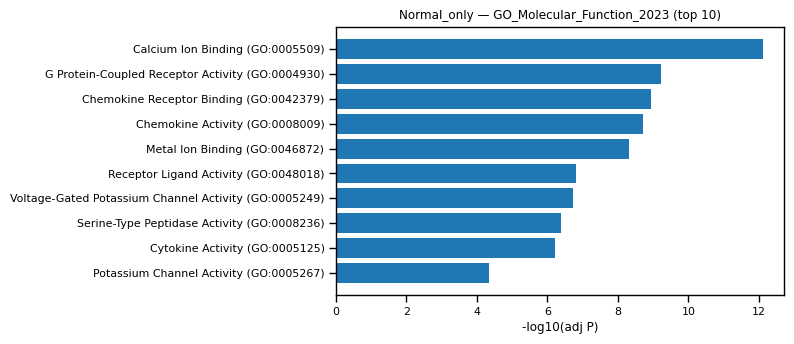

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Normal_only_GO_Molecular_Function_2023.png


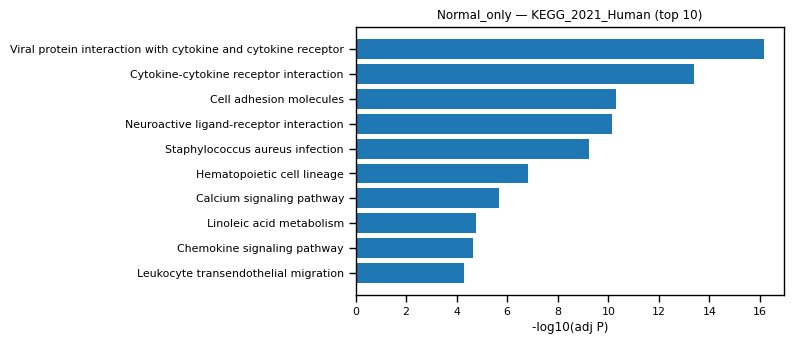

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Normal_only_KEGG_2021_Human.png


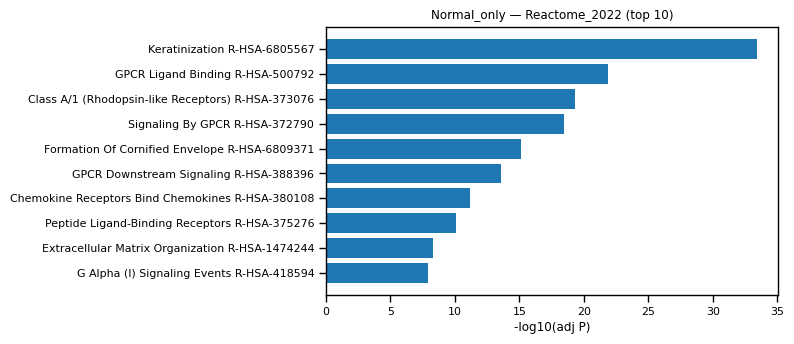

[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_bar_Normal_only_Reactome_2022.png
[WRITE] /Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min/enrichr_ALL_BUCKETS.tsv


In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gseapy as gp

if "OUTDIR" not in globals():
    OUTDIR = "/Users/shreyababare/Desktop/Data Science Final Project/mir100HG_FIN/output/DEA_SKCM/SKCM_compare_py_min"
os.makedirs(OUTDIR, exist_ok=True)

def _cat_row(r):
    if r.sig_tum and r.sig_norm:
        return "Concordant" if r.dir_tum == r.dir_norm else "Discordant"
    if r.sig_tum and not r.sig_norm:
        return "Tumour-only"
    if r.sig_norm and not r.sig_tum:
        return "Normal-only"
    return "NS"

if "cat" not in merged.columns:
    merged["cat"] = [_cat_row(r) for r in merged.itertuples()]

merged["Symbol"] = merged["Symbol"].astype(str).str.split(".").str[0].str.strip()
merged = merged[merged["Symbol"].ne("")]

bucket_lists = {
    "Concordant_UP_UP": merged.query('sig_tum & sig_norm & dir_tum=="UP"   & dir_norm=="UP"')["Symbol"].dropna().unique().tolist(),
    "Concordant_DOWN_DOWN": merged.query('sig_tum & sig_norm & dir_tum=="DOWN" & dir_norm=="DOWN"')["Symbol"].dropna().unique().tolist(),
    "Tumour_only": merged.query('sig_tum & ~sig_norm')["Symbol"].dropna().unique().tolist(),
    "Normal_only": merged.query('sig_norm & ~sig_tum')["Symbol"].dropna().unique().tolist(),
}

universe = merged["Symbol"].dropna().unique().tolist()
pd.Series(universe, name="Symbol").to_csv(os.path.join(OUTDIR, "universe_symbols.tsv"), sep="\t", index=False)

LIBRARIES = [
    "GO_Biological_Process_2023",
    "GO_Molecular_Function_2023",
    "GO_Cellular_Component_2023",
    "Reactome_2022",
    "KEGG_2021_Human",
]

def run_enrichr_for_list(list_name, genes, libraries, outdir):
    out_all = []
    if len(genes) < 5:
        print(f"[SKIP] {list_name}: too few genes ({len(genes)}).")
        return pd.DataFrame()

    for lib in libraries:
        try:
            enr = gp.enrichr(
                gene_list=genes,
                gene_sets=lib,
                organism="Human",
                cutoff=1.0,   
                no_plot=True,
                outdir=None,
            )
            if enr is None or enr.results is None or enr.results.empty:
                print(f"[INFO] No terms returned for {list_name} in {lib}.")
                continue
            df = enr.results.copy()
            df["bucket"] = list_name
            df["library"] = lib
            out_all.append(df)
            # Save per-library TSV
            df.sort_values("Adjusted P-value", ascending=True)\
              .to_csv(os.path.join(outdir, f"enrichr_{list_name}_{lib}.tsv"), sep="\t", index=False)
        except Exception as e:
            print(f"[WARN] Enrichment failed for {list_name} in {lib}: {e}")
            continue

    if out_all:
        all_df = pd.concat(out_all, ignore_index=True)
        all_df.sort_values(["library", "Adjusted P-value"], ascending=[True, True])\
              .to_csv(os.path.join(outdir, f"enrichr_{list_name}_ALL.tsv"), sep="\t", index=False)
        return all_df
    return pd.DataFrame()

def barplot_top_terms(df, list_name, topn=10):
    if df.empty:
        return
    for lib, g in df.groupby("library"):
        gg = g.sort_values("Adjusted P-value", ascending=True).head(topn)
        if gg.empty:
            continue
        xlabels = gg["Term"].astype(str).values
        scores = -np.log10(gg["Adjusted P-value"].replace(0, np.nextafter(0, 1)))  # avoid -inf

        plt.figure(figsize=(8, max(3, 0.35*len(gg))))
        y_pos = np.arange(len(gg))
        plt.barh(y_pos, scores)
        plt.yticks(y_pos, xlabels)
        plt.gca().invert_yaxis()
        plt.xlabel("-log10(adj P)")
        plt.title(f"{list_name} — {lib} (top {len(gg)})")
        plt.tight_layout()
        fpath = os.path.join(OUTDIR, f"enrichr_bar_{list_name}_{lib}.png")
        plt.savefig(fpath, dpi=180)
        plt.show()
        plt.close()
        print("[WRITE]", fpath)

all_enrich = []
for name, genes in bucket_lists.items():
    print(f"[ENRICH] {name} (n={len(genes)})")
    df = run_enrichr_for_list(name, genes, LIBRARIES, OUTDIR)
    if not df.empty:
        all_enrich.append(df)
        barplot_top_terms(df, name, topn=10)

if all_enrich:
    comb = pd.concat(all_enrich, ignore_index=True)
    comb.to_csv(os.path.join(OUTDIR, "enrichr_ALL_BUCKETS.tsv"), sep="\t", index=False)
    print("[WRITE]", os.path.join(OUTDIR, "enrichr_ALL_BUCKETS.tsv"))
else:
    print("[INFO] No enrichment results to combine.")
